# 0 Agricultural carbon绘制图

## 0.1 Load data

In [77]:
import sys
import os
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

DATA_PATH = Path(project_root, 'data')

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from function import *  

PATHS.update({'us_pv_embedding': DATA_PATH / 'training_embedding.csv'})

def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped

# 读取数据
df_agricultural_carbon = pd.read_csv('../data/4.1 Restoration_strategy_data.csv')
us_nation = gpd.read_file(r'..\data\US_data\cb_2018_us_nation_5m.shp')
df_embedding = load_embedding(PATHS['us_pv_embedding'])

usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)

df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

df_agricultural_carbon = df_agricultural_carbon[
    (df_agricultural_carbon['lon'] >= usa_bounds_main['lon_min']) &
    (df_agricultural_carbon['lon'] <= usa_bounds_main['lon_max']) &
    (df_agricultural_carbon['lat'] >= usa_bounds_main['lat_min']) &
    (df_agricultural_carbon['lat'] <= usa_bounds_main['lat_max'])
]
df_embedding = clip_data_with_us_states(df_embedding, us_nation)
df_agricultural_carbon=clip_data_with_us_states(df_agricultural_carbon,us_nation)

df_agricultural_carbon_fill   = fill_nonpositive_with_nearest(df_agricultural_carbon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_agricultural_carbon_fill = filter_duplicates(df_agricultural_carbon_fill, df_embedding_fill)

PERENNIAL_KEYWORDS = [
    'Alfalfa','Banana','Citrus','Cocoa','Coffee','Coconut',
    'Oil palm','Rubber','Sugarcane','Tea'
]
perennial_columns = [col for col in df_agricultural_carbon_fill.columns if any(keyword in col for keyword in PERENNIAL_KEYWORDS)]








列 GDPpc 没有需要填充的非正值或NaN值
列 gdmp 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值


## 0.2 Perennial crops suitability level 

In [79]:
# 完善后的代码

# 构建多年生作物适宜性 DataFrame
perennial_df = df_agricultural_carbon_fill[perennial_columns + ['lat', 'lon', 'area_m2']].copy()

# 判断不同等级的掩码
# 仅出现1（即有作物列至少为1，且所有列都不为2）
mask_only_1 = ((perennial_df[perennial_columns] == 1).any(axis=1)) & (~(perennial_df[perennial_columns] == 2).any(axis=1))

# 仅出现2（即有作物列至少为2，且所有列都不为1）
mask_only_2 = ((perennial_df[perennial_columns] == 2).any(axis=1)) & (~(perennial_df[perennial_columns] == 1).any(axis=1))

# 既出现1又出现2（即有作物列为1，且同一行有作物列为2）——将这部分计为优质土地，与mask_only_1合并统计
mask_1_and_2 = ((perennial_df[perennial_columns] == 1).any(axis=1)) & ((perennial_df[perennial_columns] == 2).any(axis=1))

# 其余情况：所有值都不是1和2，且至少有一个作物列>=3
mask_rest_3plus = (~(perennial_df[perennial_columns] == 1).any(axis=1)) & \
                  (~(perennial_df[perennial_columns] == 2).any(axis=1)) & \
                  ((perennial_df[perennial_columns] >= 3).any(axis=1))


# 计算每类状态的面积，分别列出各自面积，不合并
# 1. ==1 only
# 2. ==2 only
# 3. 既有1又有2（1&2 同时出现）
# 4. 其它≥3

area_vals = [
    perennial_df.loc[mask_only_1, 'area_m2'].sum(),      # 仅为1
    perennial_df.loc[mask_only_2, 'area_m2'].sum(),      # 仅为2
    perennial_df.loc[mask_1_and_2, 'area_m2'].sum(),     # 同时有1和2
    perennial_df.loc[mask_rest_3plus, 'area_m2'].sum()   # 其它≥3
]

total_area = sum(area_vals)

# 统一为ha和百分比
area_kha = [val / 1e7 for val in area_vals]  # kha
area_percent = [val / total_area * 100 if total_area > 0 else 0 for val in area_vals]

# 构建结果DataFrame
area_sum_df = pd.DataFrame({
    'status': ['==1 only', '==2 only', '==1&2 both', '>=3 or higher'],
    'area_kha': area_kha,
    'percent_of_total': area_percent
})

print(area_sum_df)
area_sum_df

          status     area_kha  percent_of_total
0       ==1 only   124.365180          2.644179
1       ==2 only   881.259281         18.736814
2     ==1&2 both    72.101147          1.532972
3  >=3 or higher  3625.631574         77.086035


,status,area_kha,percent_of_total
0,==1 only,124.365180,2.644179
1,==2 only,881.259281,18.736814
2,==1&2 both,72.101147,1.532972
3,>=3 or higher,3625.631574,77.086035


In [80]:
perennial_df

,Sugarcane_1981-2010_Historical_With CO2 Fertilization,Coconut_1981-2010_Historical_With CO2 Fertilization,Rubber_1981-2010_Historical_With CO2 Fertilization,Oil palm_1981-2010_Historical_With CO2 Fertilization,Citrus_1981-2010_Historical_With CO2 Fertilization,Tea_1981-2010_Historical_With CO2 Fertilization,Banana_1981-2010_Historical_With CO2 Fertilization,Cocoa_1981-2010_Historical_With CO2 Fertilization,Alfalfa_1981-2010_Historical_With CO2 Fertilization,Coffee_1981-2010_Historical_With CO2 Fertilization,lat,lon,area_m2
0,5.0,5.0,4.0,5.0,6.0,5.0,6.0,5.0,6.0,5.0,25.295834,-80.287500,776295.361002
1,6.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,25.437500,-80.537500,775385.854124
2,6.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,25.437500,-80.495834,775385.854124
3,6.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,25.445833,-80.454170,775332.207938
4,6.0,5.0,4.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,25.445833,-80.404170,775332.207938
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70332,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,5.0,8.0,48.995834,-99.995834,563356.382622
70333,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,5.0,8.0,48.995834,-99.987500,563356.382622
70334,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,5.0,8.0,48.995834,-99.895836,563356.382622
70335,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,5.0,8.0,48.995834,-99.887500,563356.382622


In [81]:
# 检查是否会存在重复值

perennial_extract_dfs = []

for keyword in PERENNIAL_KEYWORDS:
    # 找出所有与该作物关键字匹配的列
    crop_columns = [col for col in perennial_columns if keyword in col]
    if not crop_columns:
        continue  # 如果该作物没有匹配，跳过
    # 选出任一相关列值为1或2的位置
    mask = (df_agricultural_carbon_fill[crop_columns] == 1) | (df_agricultural_carbon_fill[crop_columns] == 2)
    suitable_mask = mask.any(axis=1)
    # 构建该作物的中间结果
    crop_df = df_agricultural_carbon_fill.loc[suitable_mask, crop_columns + ['lat', 'lon', 'area_m2']].copy()
    crop_df['crop'] = keyword
    perennial_extract_dfs.append(crop_df)

# 合并所有作物的结果
perennial_extract_df = pd.concat(perennial_extract_dfs, ignore_index=True) if perennial_extract_dfs else pd.DataFrame()

# 检查是否存在重复（同一lat/lon组合是否多次出现）
duplicates_latlon = perennial_extract_df.duplicated(subset=['lat', 'lon'], keep=False)
num_duplicates_latlon = duplicates_latlon.sum()

print(f"相同 lat/lon 组合的重复行数: {num_duplicates_latlon}")
if num_duplicates_latlon > 0:
    print("存在相同 lat/lon 组合的重复值。可以用 drop_duplicates(subset=['lat', 'lon']) 去重。")

# 如需去重，使用如下代码（可选）:
perennial_extract_df = perennial_extract_df.drop_duplicates(subset=['lat', 'lon'])

perennial_extract_df

相同 lat/lon 组合的重复行数: 5145
存在相同 lat/lon 组合的重复值。可以用 drop_duplicates(subset=['lat', 'lon']) 去重。


,Alfalfa_1981-2010_Historical_With CO2 Fertilization,lat,lon,area_m2,crop,Banana_1981-2010_Historical_With CO2 Fertilization,Citrus_1981-2010_Historical_With CO2 Fertilization,Cocoa_1981-2010_Historical_With CO2 Fertilization,Coffee_1981-2010_Historical_With CO2 Fertilization,Coconut_1981-2010_Historical_With CO2 Fertilization,Oil palm_1981-2010_Historical_With CO2 Fertilization,Rubber_1981-2010_Historical_With CO2 Fertilization,Sugarcane_1981-2010_Historical_With CO2 Fertilization,Tea_1981-2010_Historical_With CO2 Fertilization
0,2.0,26.004168,-97.520836,771700.453607,Alfalfa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,26.029167,-97.554170,771536.128139,Alfalfa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,26.037500,-97.545830,771481.320343,Alfalfa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,26.070833,-97.520836,771261.919395,Alfalfa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,26.070833,-97.504166,771261.919395,Alfalfa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18983,NaN,35.945835,-83.829170,695119.735577,Tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
18984,NaN,36.320835,-80.554170,691805.997452,Tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
18986,NaN,37.179165,-75.954170,684109.937590,Tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
18987,NaN,37.270832,-75.970830,683278.917831,Tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


## 0.3 Maps of crop distribution 

### helper function

In [82]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box, LineString
from shapely.ops import unary_union
try:
    from shapely import make_valid
except Exception:
    make_valid = None
import rioxarray
from shapely.geometry import mapping

def _render_terrain(ax, dem_data, usa_bounds_main, transformer):
    """渲染地形"""
    qm = None
    dem_lon = dem_data.x.values
    dem_lat = dem_data.y.values
    lon_mask = (dem_lon >= usa_bounds_main['lon_min']) & (dem_lon <= usa_bounds_main['lon_max'])
    lat_mask = (dem_lat >= usa_bounds_main['lat_min']) & (dem_lat <= usa_bounds_main['lat_max'])
    
    if lon_mask.any() and lat_mask.any():
        lon_idx = np.where(lon_mask)[0]
        lat_idx = np.where(lat_mask)[0]
        
        # 抽稀栅格
        step_x = max(1, len(lon_idx)//1800)
        step_y = max(1, len(lat_idx)//900)
        lon_sub = lon_idx[::step_x]
        lat_sub = lat_idx[::step_y]
        elev = dem_data.squeeze().values[np.ix_(lat_sub, lon_sub)]

        mask = ~np.isnan(elev)
        if mask.any():
            lo = np.nanpercentile(elev, 35)
            elev[elev < lo] = np.nan

            # 地形配色
            terrain_colors = ListedColormap(["#ffffff", "#eef3ef", "#dfe8e0",
                                           "#d2ddcf", "#c7d1c1", "#b7c2af"])
            terrain_colors.set_bad((0, 0, 0, 0))
            qs = np.nanpercentile(elev, [35, 50, 65, 78, 88, 98])
            norm = BoundaryNorm(qs, terrain_colors.N)

            lon_grid, lat_grid = np.meshgrid(dem_lon[lon_sub], dem_lat[lat_sub])
            gx, gy = transformer.transform(lon_grid, lat_grid)            
            qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,
                              shading='auto', alpha=0.55, antialiased=False, zorder=1)
            qm.set_clip_on(True)
    
    return qm


def _draw_glow_outline_outside(ax, gdf_albers, line_color="#444444", line_width=0.8,
                              widths_km=(0, 30, 50), alphas=(0.95, 0.5, 0.3), 
                              colors=("#08336e", "#105ca4", "#3888c0")):
    """绘制国界线光晕效果"""
    g = gdf_albers.copy()
    geom = unary_union(g.geometry)
    
    if make_valid is not None:
        geom = make_valid(geom)
    else:
        geom = geom.buffer(0)

    radii_m = [k*1000.0 for k in widths_km]
    ordered = list(zip(radii_m, alphas, colors))
    ordered.sort(key=lambda x: x[0])

    last_inner = geom.buffer(0, join_style=2, cap_style=2)
    glow_meshes = []
    
    for i, (r, alpha, color) in enumerate(ordered):
        outer = geom.buffer(r, join_style=2, cap_style=2)
        ring = outer.difference(last_inner)
        if not ring.is_empty:
            glow_series = gpd.GeoSeries([ring], crs=g.crs)
            glow_mesh = glow_series.plot(ax=ax, color=color, alpha=alpha, edgecolor="none",
                                       zorder=8.2 + i*0.01)
            glow_meshes.append(glow_mesh)
        last_inner = outer

    g.boundary.plot(ax=ax, color=line_color, linewidth=line_width, zorder=9.6)
    return glow_meshes


def _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """绘制经纬度网格，标签显示在上方和左侧（曲线网格）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 绘制曲线网格线
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 在顶部显示标签
        p = _choose_point_on_edge(line.intersection(top))
        if p is not None:
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                ax.text(p.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 绘制曲线网格线
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧显示标签
        p = _choose_point_on_edge(line.intersection(left))
        if p is not None:
            yticks.append(p.y)
            ax.text(xmin - (xmax - xmin) * 0.02, p.y, f"{int(round(lat))}°N",
                   ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                           edgecolor='none'))



### Plot function

In [83]:

def plot_perennial_crops(
    perennial_df,
    perennial_extract_df,
    us_states_gdf,
    us_nation_gdf,
    dem_data=None,
    title="Perennial Crops Suitability",
    background_alpha=0.3,
    highlight_alpha=0.9,
    highlight_color='#ff4444'
):
    """
    绘制多年生作物适宜性分布图
    
    Parameters:
    -----------
    perennial_df : DataFrame
        所有多年生作物数据（背景，较淡）
    perennial_extract_df : DataFrame
        适宜性等级为1或2的像元（前景，鲜艳）
    us_states_gdf : GeoDataFrame
        美国州界数据
    us_nation_gdf : GeoDataFrame
        美国国界数据
    dem_data : xarray.Dataset, optional
        DEM地形数据
    title : str, optional
        图表标题
    background_alpha : float, default 0.3
        背景数据点的透明度
    highlight_alpha : float, default 0.9
        高亮数据点的透明度
    highlight_color : str, default '#ff4444'
        高亮数据点的颜色（鲜艳的红色）
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })

    # 创建图形和坐标轴
    fig, ax = plt.subplots(1, 1, figsize=(150/25.4, 90/25.4))  
    ax.set_autoscale_on(False)
    fig.patch.set_facecolor('white')      

    # ==================== 地理边界设置 ====================
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    
    # 处理州界数据
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    
    # 处理国界线
    us_nation_bound = us_nation_gdf.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')

    # ==================== 坐标变换设置 ====================
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    # ==================== 地图范围计算 ====================
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds

    # 减小边界，让图幅更大
    margin_x = (xmax - xmin) * 0.02  
    margin_y = (ymax - ymin) * 0.02
    
    xmin = xmin - margin_x
    xmax = xmax + margin_x
    ymin = ymin - margin_y
    ymax = ymax + margin_y

    # 设置坐标轴位置和范围
    ax.set_position([0.07, 0.17, 0.9, 0.9])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ==================== 地形渲染 ====================
    qm = None
    if dem_data is not None:
        qm = _render_terrain(ax, dem_data, usa_bounds_main, transformer)

    # ==================== 地图元素绘制 ====================
    # 绘制国界线光晕效果
    _draw_glow_outline_outside(ax, us_nation_albers)
    
    # 绘制州界
    us_states_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4, alpha=0.4, zorder=9)

    # ==================== 取消坐标轴和网格 ====================
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    lon_ticks = np.arange(-115, -65, 10)
    lat_ticks = [30, 35, 40, 45]
    
    # 绘制曲线网格线
    _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)

    # ==================== 数据可视化 ====================
    # 1. 绘制背景数据（perennial_df）- 较淡的颜色
    if len(perennial_df) > 0:
        x_bg, y_bg = transformer.transform(perennial_df['lon'].values, 
                                           perennial_df['lat'].values)
        # 使用更深的黄色作为背景
        ax.scatter(x_bg, y_bg, c='#ffe082', s=0.2, alpha=background_alpha, 
                  edgecolors='none', zorder=3, label='All perennial crops')

    # 2. 绘制高亮数据（perennial_extract_df）- 鲜艳的颜色
    if len(perennial_extract_df) > 0:
        x_hl, y_hl = transformer.transform(perennial_extract_df['lon'].values, 
                                          perennial_extract_df['lat'].values)
        # 使用鲜艳的颜色标记适宜性等级为1或2的像元
        ax.scatter(x_hl, y_hl, c=highlight_color, s=0.5, alpha=highlight_alpha, 
                  edgecolors='none', zorder=6, label='Suitability level 1-2')

    # ==================== 添加图例（左下角）====================
    # 创建自定义图例元素
    from matplotlib.patches import Rectangle
    
    # 直接按间距绘制两个图例项（无图例框）
    # 计算左下角参考位置
    legend_x = xmin + (xmax - xmin) * 0.025  # 距离左边界2.5%
    legend_y = ymin + (ymax - ymin) * 0.03   # 距离下边界3%
    legend_padding = (ymax - ymin) * 0.04    # 项间距

    marker_size = 8

    # 1. Perennial crops (多年生作物) - 红色
    ax.scatter(legend_x, legend_y + legend_padding, 
               c=highlight_color, s=marker_size, alpha=highlight_alpha, 
               edgecolors='none', zorder=51)
    ax.text(legend_x + legend_padding * 1.5, legend_y + legend_padding, 
            'Perennial crops', fontsize=5, va='center', ha='left', 
            zorder=52, color='#333333', fontweight='normal')

    # 2. Annual crops (一年生作物) - 黄色
    annual_color = '#ffd700'
    ax.scatter(legend_x, legend_y, 
               c=annual_color, s=marker_size, alpha=0.8, 
               edgecolors='none', zorder=51)
    ax.text(legend_x + legend_padding * 1.5, legend_y, 
            'Annual crops', fontsize=5, va='center', ha='left', 
            zorder=52, color='#333333', fontweight='normal')

    # ==================== 最终处理 ====================
    fig.canvas.draw()          
    if qm is not None:
        qm.set_clip_path(ax.patch)
        qm.set_rasterized(True)

    return fig, ax


In [84]:
# 加载DEM数据和州界数据（如果需要地形渲染）
try:
    import rioxarray
    dem = rioxarray.open_rasterio(DATA_PATH.parent / 'figure' / 'draw_shp' / 'DEM.nc', masked=True)
    if dem.rio.crs is None:
        dem = dem.rio.write_crs("EPSG:4326")
    # 裁剪DEM到美国范围
    dem_us = dem.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)
    print("DEM数据加载成功")
except Exception as e:
    print(f"DEM数据加载失败: {e}")
    dem_us = None

DEM数据加载成功


C:\Users\zpy10\AppData\Local\Temp\ipykernel_32832\2863847703.py:49: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


图片已保存到: Supplymentary_figure\perennial_crops_suitability.png


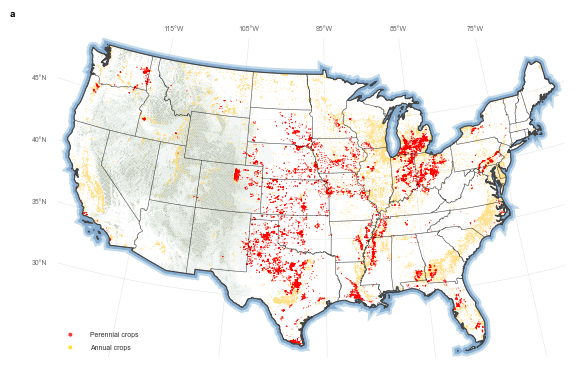

In [87]:


# 加载州界数据
us_states = gpd.read_file(DATA_PATH / 'cb_2018_us_state_500k.shp')

# 使用绘图函数
fig, ax = plot_perennial_crops(
    perennial_df=perennial_df,
    perennial_extract_df=perennial_extract_df,
    us_states_gdf=us_states,
    us_nation_gdf=us_nation,
    dem_data=dem_us,  
    title="Perennial Crops Suitability Distribution",
    background_alpha=0.8,  # 背景透明度
    highlight_alpha=0.8,   # 高亮透明度
    highlight_color='#ff0000'  # 鲜艳的红色
)

fig.text(
    0.01, 1.15, "a", ha='left', va='top', fontsize=7, fontweight='bold',
    bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100
)

# 保存图片到 Supplymentary/Supplymentary_figure
output_dir = Path('Supplymentary_figure')
output_dir.mkdir(parents=True, exist_ok=True)

filename_png = output_dir / 'perennial_crops_suitability.png'
filename_pdf = output_dir / 'perennial_crops_suitability.pdf'

fig.savefig(filename_png, dpi=300, facecolor='white', bbox_inches='tight')
fig.savefig(filename_pdf, dpi=300, facecolor='none', bbox_inches='tight')

print(f"图片已保存到: {filename_png}")
plt.show()
plt.close(fig)


# 1 Carbon Storage Maps for Three LNCS Strategies

## 1.1 Load data

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from function import *  
from shapely.geometry import mapping  

# 这段代码的作用是动态地将项目的根目录（project_root）加入到Python的sys.path中
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

DATA_PATH = Path(project_root, 'data')
PATHS.update({'us_pv_embedding': DATA_PATH / 'training_embedding.csv'})

df_weight = pd.read_csv('../data/US_data/df_weight.csv')
us_nation = gpd.read_file(r'..\data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'..\data\cb_2018_us_state_500k.shp')

# 加载DEM数据和州界数据（如果需要地形渲染）
try:
    import rioxarray
    dem = rioxarray.open_rasterio(DATA_PATH.parent / 'figure' / 'draw_shp' / 'DEM.nc', masked=True)
    if dem.rio.crs is None:
        dem = dem.rio.write_crs("EPSG:4326")
    # 裁剪DEM到美国范围
    dem_us = dem.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)
    print("DEM数据加载成功")
except Exception as e:
    print(f"DEM数据加载失败: {e}")
    dem_us = None


DEM数据加载失败: Read or write failed. c:/Dev/Landuse_Zhong_clean/figure/draw_shp/DEM.nc, band 1: IReadBlock failed at X offset 2, Y offset 0: netCDF chunk fetch failed: #-101 (NetCDF: HDF error)


## 1.2 Plot (Need helper at 0.3)

In [11]:


def plot_carbon_storage_single(
    df_weight,
    col_name,
    title,
    us_states_gdf,
    us_nation_gdf,
    dem_data=None,
    figsize=(90/25.4, 60/25.4),
    vmin=None,
    vmax=None,
    cmap=None
):
    """
    绘制单个策略的碳储量分布图（采用plot_ccd_optimized_global_style_with_dem的颜色映射方式）
    
    Parameters:
    -----------
    df_weight : DataFrame
        包含lat, lon和碳储量列的数据框（已裁剪）
    col_name : str
        要绘制的列名
    title : str
        图表标题
    us_states_gdf : GeoDataFrame
        美国州界数据
    us_nation_gdf : GeoDataFrame
        美国国界数据
    dem_data : xarray.Dataset, optional
        DEM地形数据
    figsize : tuple, default (90/25.4, 60/25.4)
        图形尺寸（mm转换为英寸）
    vmin, vmax : float, optional
        颜色范围的最小值和最大值
    cmap : matplotlib colormap, optional
        颜色映射，如果为None则根据col_name自动选择
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm, ListedColormap
    from pyproj import Transformer
    from shapely.geometry import box
    
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })
    
    if cmap is None:
        if 'agro' in col_name.lower() or 'agricultural' in col_name.lower():
            cmap = plt.cm.YlOrRd
        elif 'forest' in col_name.lower():
            cmap = plt.cm.Greens
        elif 'veg' in col_name.lower() or 'vegetation' in col_name.lower():
            cmap = plt.cm.Blues
        else:
            # 更换为新配色方案：使用viridis
            cmap = plt.cm.viridis
    
    # 创建单个图形
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.patch.set_facecolor('white')
    ax.set_autoscale_on(False)
    ax.set_facecolor('white')
    
    # 地理边界设置
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    
    # 处理州界和国界数据
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    us_nation_bound = us_nation_gdf.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')
    
    # 坐标变换
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)
    
    # 地图范围
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds
    margin_x = (xmax - xmin) * 0.02
    margin_y = (ymax - ymin) * 0.02
    xmin -= margin_x
    xmax += margin_x
    ymin -= margin_y
    ymax += margin_y
    
    # 设置坐标轴位置和范围
    ax.set_position([0.07, 0.17, 0.9, 0.78])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    

    # 先获取数据用于计算bins
    bins = None
    if col_name in df_weight.columns:
        valid_values = df_weight[col_name].dropna()
        pos_all = valid_values[valid_values > 0]
        
        if len(pos_all) > 0:
            # 计算11个分位数阈值（0,10,20,30,40,50,60,70,80,90,100）
            bins = np.percentile(pos_all, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
            
            # 如果vmin/vmax未指定，使用数据的1%和99%分位数
            if vmin is None:
                vmin = np.nanpercentile(valid_values, 1)
            if vmax is None:
                vmax = np.nanpercentile(valid_values, 99)
        else:
            bins = np.linspace(0, 1, 11)
            if vmin is None:
                vmin = 0
            if vmax is None:
                vmax = 1
    else:
        bins = np.linspace(0, 1, 11)
        if vmin is None:
            vmin = 0
        if vmax is None:
            vmax = 1
    
    # 地形渲染
    qm = None
    if dem_data is not None:
        qm = _render_terrain(ax, dem_data, usa_bounds_main, transformer)
    
    # 绘制国界线光晕
    _draw_glow_outline_outside(ax, us_nation_albers)
    
    # 绘制州界
    us_states_albers.plot(ax=ax, color='none', edgecolor='black', 
                         linewidth=0.4, alpha=0.4, zorder=9)
    
    # 取消坐标轴
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # 绘制网格线
    lon_ticks = np.arange(-115, -65, 10)
    lat_ticks = [30, 35, 40, 45]
    _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, 
                              usa_bounds_main, proj_fwd, proj_inv)
    
    # 绘制数据点（参照plot_ccd_optimized_global_style_with_dem，使用BoundaryNorm）
    scatter = None
    if col_name in df_weight.columns:
        data_subset = df_weight[['lat', 'lon', col_name]].dropna()
        if len(data_subset) > 0:
            x_proj, y_proj = transformer.transform(
                data_subset['lon'].values,
                data_subset['lat'].values
            )
            values = data_subset[col_name].values

            cmap_colors = [cmap(i/10.0) for i in range(11)]
            carbon_cmap = LinearSegmentedColormap.from_list("carbon_cmap", cmap_colors, N=11)
            
            # 使用之前计算的bins，如果bins为None则重新计算
            if bins is None:
                pos_all = values[values > 0]
                if len(pos_all) > 0:
                    bins = np.percentile(pos_all, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
                else:
                    bins = np.linspace(vmin if vmin is not None else 0, vmax if vmax is not None else 1, 11)
            
            # 使用BoundaryNorm
            carbon_norm = BoundaryNorm(bins, ncolors=carbon_cmap.N)
            
            # 对于0值或负值，使用灰色
            values_plot = values.copy()
            colors_plot = []
            for v in values:
                if v <= 0:
                    colors_plot.append('lightgray')
                else:
                    # 使用norm来映射颜色
                    colors_plot.append(carbon_cmap(carbon_norm(v)))
            
            # 使用scatter绘制
            scatter = ax.scatter(x_proj, y_proj, c=colors_plot, s=0.3, alpha=0.8,
                                edgecolors='none', zorder=5)

    
    if scatter is not None and bins is not None:
        # 确保carbon_cmap和carbon_norm已定义（如果未定义则创建）
        if 'carbon_cmap' not in locals() or carbon_cmap is None:
            # 从cmap中提取11个颜色
            cmap_colors = [cmap(i/10.0) for i in range(11)]
            carbon_cmap = LinearSegmentedColormap.from_list("carbon_cmap", cmap_colors, N=11)
        
        if 'carbon_norm' not in locals() or carbon_norm is None:
            # 使用BoundaryNorm
            carbon_norm = BoundaryNorm(bins, ncolors=carbon_cmap.N)
        
        # colorbar位置和大小
        pos = ax.get_position()
        c_w = 0.45 * pos.width
        c_h = 0.035
        c_left = pos.x0 + 0.25 * pos.width
        c_bottom = 0.09
        cax = fig.add_axes([c_left, c_bottom, c_w, c_h])
        cax.set_in_layout(False)
        
        # 创建colorbar
        from matplotlib.cm import ScalarMappable
        sm = ScalarMappable(cmap=carbon_cmap, norm=carbon_norm)
        sm.set_array([])
        cb = fig.colorbar(sm, cax=cax, orientation='horizontal')
        cb.set_ticks(bins[1::2])
        cb.set_ticklabels([f"{v:.2f}" for v in bins[1::2]])
        
        # tick样式（参照plot_ccd_optimized_global_style_with_dem）
        cax.tick_params(axis='x', which='major', length=2.5, width=0.5, pad=1, labelsize=5)
        cax.tick_params(axis='x', which='minor', length=1.5, width=0.4, label1On=False)
        cb.outline.set_linewidth(0.7)
        
        # 顶部Top%标签（参照plot_ccd_optimized_global_style_with_dem）
        top_labels = [f"Top{p}" for p in range(10, 101, 20)][::-1]  # ['Top90', 'Top70', 'Top50', 'Top30', 'Top10']
        for loc, lab in zip(cb.get_ticks(), top_labels):
            x_disp = cax.transData.transform((loc, 0))[0]
            x_frac = cax.transAxes.inverted().transform((x_disp, 0))[0]
            cax.text(x_frac, 1.15, lab, transform=cax.transAxes,
                     ha='center', va='bottom', fontsize=5)
        
        unit_display = "Carbon Storage (MgC/ha)"
        cax.text(0.5, -1.4, unit_display, ha='center', va='top', fontsize=5, 
                fontweight='bold', transform=cax.transAxes)
    
    # 最终处理
    if qm is not None:
        qm.set_clip_path(ax.patch)
        qm.set_rasterized(True)
    
    fig.canvas.draw()
    
    return fig, ax


In [12]:

all_values = []
for col in ['final_agro', 'final_forest', 'final_veg']:
    if col in df_weight.columns:
        valid_values = df_weight[col].dropna()
        if len(valid_values) > 0:
            all_values.extend(valid_values.values)

if len(all_values) > 0:
    import numpy as np
    vmin_common = np.nanpercentile(all_values, 1)
    vmax_common = np.nanpercentile(all_values, 99)
else:
    vmin_common, vmax_common = None, None

# 三个策略的配置
strategies = [
    ('final_agro', 'Agricultural'),
    ('final_forest', 'Forest'),
    ('final_veg', 'Vegetation')
]

# 绘制每个策略的单独图
output_dir = Path('Supplymentary_figure')
output_dir.mkdir(parents=True, exist_ok=True)
panel_labels = ['a', 'b', 'c']

figs = []
for i, (col, title) in enumerate(strategies):
    fig, ax = plot_carbon_storage_single(
        df_weight=df_weight,
        col_name=col,
        title=title,
        us_states_gdf=us_states,
        us_nation_gdf=us_nation,
        dem_data=dem_us,
        figsize=(88/25.4, 60/25.4)
    )
    # 加上panel标签
    fig.text(
        0.01, 0.99, panel_labels[i], ha='left', va='top', fontsize=7, fontweight='bold',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.2, lw=0), zorder=100
    )
    filename_png = output_dir / f'carbon_storage_{col}.png'
    filename_pdf = output_dir / f'carbon_storage_{col}.pdf'
    
    fig.savefig(filename_png, dpi=300, facecolor='white')
    fig.savefig(filename_pdf, dpi=300, facecolor='none')
    
    print(f"图片已保存到: {filename_png}")
    figs.append((fig, col))
    plt.close(fig)

    filename_png = output_dir / f'carbon_storage_{col}.png'
    filename_pdf = output_dir / f'carbon_storage_{col}.pdf'
    
    fig.savefig(filename_png, dpi=300, facecolor='white')
    fig.savefig(filename_pdf, dpi=300, facecolor='none')
    
    print(f"图片已保存到: {filename_png}")
    figs.append((fig, col))
    plt.close(fig)

panel_labels = ['d']

# 计算加权组合：final_agro*weighted_density_Agricultural + final_forest*weighted_density_Forest + final_veg*weighted_density_Vegetation
if all(col in df_weight.columns for col in ['final_agro', 'final_forest', 'final_veg', 
                                             'weighted_density_Agricultural', 
                                             'weighted_density_Forest', 
                                             'weighted_density_Vegetation']):
    df_weight['weighted_combined'] = (
        df_weight['final_agro'] * df_weight['weighted_density_Agricultural'] +
        df_weight['final_forest'] * df_weight['weighted_density_Forest'] +
        df_weight['final_veg'] * df_weight['weighted_density_Vegetation']
    )
    
    # 绘制加权组合图
    fig, ax = plot_carbon_storage_single(
        df_weight=df_weight,
        col_name='weighted_combined',
        title='Weighted Combined',
        us_states_gdf=us_states,
        us_nation_gdf=us_nation,
        dem_data=dem_us,
        figsize=(88/25.4, 60/25.4)
    )
    fig.text(
        0.01, 0.99, panel_labels[0], ha='left', va='top', fontsize=7, fontweight='bold',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.2, lw=0), zorder=100
    )
    filename_png = output_dir / 'carbon_storage_weighted_combined.png'
    filename_pdf = output_dir / 'carbon_storage_weighted_combined.pdf'
    
    fig.savefig(filename_png, dpi=300, facecolor='white')
    fig.savefig(filename_pdf, dpi=300, facecolor='none')
    
    print(f"加权组合图已保存到: {filename_png}")
    plt.close(fig)
else:
    print("警告：缺少必要的列来计算加权组合图")
    missing_cols = []
    for col in ['final_agro', 'final_forest', 'final_veg', 
                'weighted_density_Agricultural', 'weighted_density_Forest', 'weighted_density_Vegetation']:
        if col not in df_weight.columns:
            missing_cols.append(col)
    print(f"缺少的列: {missing_cols}")


图片已保存到: Supplymentary_figure\carbon_storage_final_agro.png
图片已保存到: Supplymentary_figure\carbon_storage_final_agro.png
图片已保存到: Supplymentary_figure\carbon_storage_final_forest.png
图片已保存到: Supplymentary_figure\carbon_storage_final_forest.png
图片已保存到: Supplymentary_figure\carbon_storage_final_veg.png
图片已保存到: Supplymentary_figure\carbon_storage_final_veg.png
加权组合图已保存到: Supplymentary_figure\carbon_storage_weighted_combined.png


# 2 Carbon sensitivity anlysis 


核心目的，我需要计算二氧化碳减排能力的敏感性

由于LNCS的数量级远小于PV发电能力，因此主要考虑3个方面的参数，由这三个参数共同组成，需要你生成由不同情境构成的dataframe。

 第一，不同的情景，主要影响emission_intensity水平（来自IEA的2个场景、包含一个base；以及US EIA的7个场景）；
 每个场景初步设想根据base调整未来的carbon演变方向，代表了emission intensity朝着不同方向演化。
 emission intensity代表了未来情景下排放的不同模式
 
 
 第二，不同的abandoned land availibility，abandoned land avalability, ranging from 60%-100% in US。 we use 100% for base，需要以10%为间隔从range[0.6, 1.01, step==0.1],一共5个取值
 
 第三，panel efficiency, ranging from [0.15,0.22,step==0.1],一共7个值



base 默认值为2020的静态值：352 gCO2/kWh。这个数值的原始来源是根据当前替代的OM以及未来建设BM综合测算而得，这个数值是pv_transform_2020，之后的数据都需要根据不同场景下得出的scaling_factors去进行调整到2050年；

**Base输入数据**示例：
'''
首先是来自IEA的情景数据
 ├── 场景1 (stated policy)
首先是来自IEA的情景数据
emission_intensity = pd.DataFrame({
    'Scenario': ['State policy from IEA'] * 4,
    'year': [2018, 2030, 2035, 2040],
    'CO2_g_per_kWh': [400.3, 302, 279.2, 261.1]
})
emission_intensity = pd.DataFrame({
    'Scenario': [' from IEA'] * 4,
    'year': [2018, 2030, 2035, 2040],
    'CO2_g_per_kWh': [400.3, 302, 279.2, 261.1]
})
其次是来自EIA的情景数据
提取方法方法如下：

```python
import pandas as pd 
import glob

# 获取所有Supplymentary/Carbon_sensitivity/目录下以A_A14开头的xlsx文件
files = glob.glob(r'Supplymentary/Carbon_sensitivity/A_A14*.xlsx')

# 读取所有文件并存储到一个list
carbon_eia_list = [pd.read_excel(f) for f in files]
# 循环每个carbon_eia_list中的DataFrame，并储存每个的处理结果
region_fuel_data_list = []
for carbon_eia in carbon_eia_list:
    region_and_fuel_row = carbon_eia[carbon_eia['International Energy Outlook 2023'] == 'Region and fuel'].iloc[0, 1:-1]
    region_fuel_row_index = carbon_eia[carbon_eia['International Energy Outlook 2023'] == '  United States'].index[0]
    region_fuel_row_and_next5 = carbon_eia.loc[region_fuel_row_index:region_fuel_row_index + 4].copy()
    region_fuel_row_and_next5.columns = ['International Energy Outlook 2023'] + list(region_and_fuel_row) + ['rate']
    region_fuel_data_list.append(region_fuel_row_and_next5)
    
region_fuel_data_list[0]
```
其中，该代码部分的年份需要注意，进一步提取2022.0，2030.0, 2040.0,2050.0
'''

**Base计算逻辑**示例：
'''
-- 根据输入的df_matrix组成数据组合row，计算未修正carbon emission

```python
import pandas as pd
import numpy as np

def compute_pv_potential_fixed(
    df: pd.DataFrame,
    rsds_col: str = 'rsds',
    tas_col: str = 'tas',
    wind_col: str = 'wind',
    lat_col: str = 'lat',
    lom_col: str = 'lon',
    eta_stc: float = 0.17,
    eta_sys: float = 0.8,
    pixel_size_deg: float = 0.0083333
) -> pd.DataFrame:
    """
    修正后的思路A：假设 df['rsds'] 已经是 “物理上的 MJ/m²/d”。
    -------------------------------------------------------------
    1) I (W/m²) = df['rsds'] (MJ/m²/d) * 1e6 (J/MJ) / 86400 (s/d)
    2) T_amb_C (℃) = df['tas']*0.1 (从 K/10 到 K) - 273.15
    3) T_cell (℃) = 4.3 + 0.943*T_amb_C + 0.028*I - 1.528*wind
    4) PR = 1 + γ*(T_cell - 25), γ = -0.005 1/℃
    5) PVPOT = PR * I / 1000
    6) area_m2 = pixel 面积
    7) E_yr_per_m2 = η_stc * PVPOT * η_sys * 8760   (kWh/m²/yr)
    8) E_yr_pixel = E_yr_per_m2 * area_m2
    """
    df = df.copy()

    # ——（1）rsds: MJ/m²/d -> I: W/m² —— 
    # 直接用物理上已经是 MJ/m²/d 的数值（无需再乘 0.001）
    df['I'] = df[rsds_col] * 1e6 / 86400.0  # W/m²

    # ——（2）T_amb_C: tas (K/10) -> ℃ ——
    # 如果 NetCDF 原始里 tas 存成 K/10，需要先乘以 0.1
    df['T_amb_C'] = df[tas_col] * 0.1 - 273.15

    # ——（3）T_cell: 经验式 —— 
    df['T_cell'] = (
        4.3
        + 0.943 * df['T_amb_C']
        + 0.028 * df['I']
        - 1.528 * df['wind']
    )

    # ——（4）PR: 性能比 —— 
    gamma = -0.005
    df['PR'] = 1 + gamma * (df['T_cell'] - 25.0)

    # ——（5）PVPOT —— 
    df['PVPOT'] = df['PR'] * df['I'] / 1000.0

    # ——（6）像素面积 area_m2 —— 
    # 地球平均半径 ~ 6 371 000 m
    R = 6371000.0
    deg2rad = np.pi / 180.0
    dlat = pixel_size_deg * deg2rad
    dlon = pixel_size_deg * deg2rad
    lat_rad = df[lat_col] * deg2rad
    df['area_m2'] = (R * dlat) * (R * dlon * np.cos(lat_rad))

    # ——（7）单位面积年发电量 E_yr_per_m2 (kWh/m²/yr) —— 
    df['E_yr_per_m2'] = eta_stc * df['PVPOT'] * eta_sys * 8760.0

    # ——（8）像素总年发电量 E_yr_pixel (kWh/yr) —— 
    df['E_yr_pixel'] = df['E_yr_per_m2'] * df['area_m2']

    return df

# 用法示例（假设 df 已加载并含“rsds($\mathrm{MJ/m^2/d}$)”，“tas($\mathrm{K/10}$)”，“wind($\mathrm{m/s}$)”，“lat”，“lon”)：
fixed_df = compute_pv_potential_fixed(us_df_abandon_filtered)
# Calculate carbon emissions


```


根据输出的df['E_yr_pixel']发电量进一步根据碳因子调整为减排能力

```python
-- 从已有年份中插值pv的转换因子到目标年份
pv_transform_2020 = 352  
years_target = [2020, 2030, 2040, 2050]
em_factors = np.interp(
    years_target,  # 目标年份
    emission_intensity['year'].astype(int),  # 已知年份
    emission_intensity['CO2_g_per_kWh']      # 已知emission intensity
    
)

scaling_factors = em_factors / em_factors[0]

pv_transfer = pd.DataFrame({
    'year': [2020, 2030, 2040, 2050],
    'pv_transform': [pv_transform_2020] + list(pv_transform_2020 * scaling_factors[1:])
})


-- 计算每10年区间的累计光伏转化能力，并最终汇总到2050--
years = [2020, 2030, 2040, 2050]

for idx in range(len(years)-1):
    y_start, y_end = years[idx], years[idx+1]
    pv_start = pv_transfer.loc[pv_transfer['year'] == y_start, 'pv_transform'].values[0]
    pv_end = pv_transfer.loc[pv_transfer['year'] == y_end, 'pv_transform'].values[0]
    # 线性插值每年pv_transform，累计10年
    pv_sum = 0
    for y in range(y_start, y_end):
        pv_y = pv_start + (pv_end - pv_start) * (y - y_start) / (y_end - y_start)
        pv_sum += merged_data_for_analysis['E_yr_pixel'] * pv_y / 1000 / 1000 * 0.27 / (merged_data_for_analysis['area_m2'] / 10000)
    merged_data_for_analysis[f'pv_potential_{y_start}_{y_end-1}_sum'] = pv_sum

-- 汇总2020-2050累计值，汇总site的累计光伏减排能力(t C)
merged_data_for_analysis['pv_potential_dens'] = sum(
    merged_data_for_analysis[f'pv_potential_{years[i]}_{years[i+1]-1}_sum'] for i in range(len(years)-1)
)
'''
```


**Base输出逻辑**示例：
输出的数据形式以字典形式存储各个不同情境的df
各个df对应了场景 (Scenario)下的减排能力


主要数据流结构

数据结构树形图

```
├── 场景 (Scenario)
│   ├── IEA stated policies (our base)
│   ├── IEA NZE 
│   ├── IEA sustainable development 
│   ├── US EIA Scenario 1
│   ├── US EIA Scenario 2
│   ├── US EIA Scenario 3
│   ├── US EIA Scenario 4
│   ├── US EIA Scenario 5
│   ├── US EIA Scenario 6
│   └── US EIA Scenario 7
│
├── Abandoned land availability (可用废弃地比例)
│   ├── 60%
│   ├── 70%
│   ├── 80%
│   ├── 90%
│   └── 100% (our base)
│
└── Panel efficiency (组件转换效率)
    ├── 0.15
    ├── 0.16
    ├── 0.17
    ├── 0.18
    ├── 0.19
    ├── 0.20
    └── 0.21
```

- 输入数据 **Abandoned land availability** 与 **Panel efficiency** 已经存储于 `matrix_df`
- 输入数据 **场景 (Scenario)** 来自 EIA 的数据，存储在 `region_fuel_data_list`

## 2.1 Load data

In [24]:
import sys
import os
from pathlib import Path

# 最可靠的方法：查找包含data和function目录的项目根目录
def find_project_root(start_path=None):
    """查找项目根目录（包含data和function目录的目录）"""
    if start_path is None:
        start_path = Path.cwd()
    
    current = Path(start_path).resolve()
    
    # 向上查找，直到找到包含data和function目录的目录
    for _ in range(5):  # 最多向上查找5层
        if (current / 'data').exists() and (current / 'function').exists():
            return current
        parent = current.parent
        if parent == current:  # 到达根目录
            break
        current = parent
    
    # 如果找不到，假设当前目录的父目录是项目根目录
    return Path.cwd().parent

project_root = find_project_root()

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

DATA_PATH = project_root / 'data'

print(f"项目根目录: {project_root}")
print(f"数据路径: {DATA_PATH}")


项目根目录: C:\Dev\Landuse_Zhong_clean
数据路径: C:\Dev\Landuse_Zhong_clean\data


In [25]:
%load_ext autoreload
%autoreload 2 
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import geopandas as gpd
from shapely.geometry import Point
from function import (
    load_embedding, load_abandon, fill_nonpositive_with_nearest, 
    filter_duplicates, NUMERIC_FEATURES, CAT_COLS, PATHS
)
from function.pipeline import run_correct_training_pipeline
from function.model_saving import save_complete_model_pipeline
from datetime import datetime
import platform
from tqdm.auto import tqdm

def normalize_path(path):
    """
    跨平台路径规范化
    将Windows路径中的反斜杠转换为正斜杠（在Linux/WSL中）
    Windows: r'data\file.shp' -> r'data\file.shp' (保持不变)
    Linux/WSL: r'data\file.shp' -> 'data/file.shp' (转换)
    """
    if isinstance(path, str):
        # 检测是否在WSL或Linux环境中
        is_linux = platform.system() in ['Linux', 'Darwin']
        
        if is_linux:
            # 在Linux/WSL中，将反斜杠转为正斜杠
            path = path.replace('\\', '/')
        
        return path
    return path

def normalize_paths_dict(paths_dict):
    """
    规范化路径字典中的所有路径
    """
    normalized = {}
    for key, value in paths_dict.items():
        normalized[key] = normalize_path(value)
    return normalized

def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped

PATHS = normalize_paths_dict(PATHS)
PATHS['us_pv_embedding'] = normalize_path(str(DATA_PATH / 'training_embedding.csv'))
PATHS['us_abandon'] = normalize_path(str(DATA_PATH / 'us_abandon_clean.csv'))
print(f"us_abandon path: {PATHS['us_abandon']}")


usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
# 加载数据
print("加载数据...")
df_embedding = load_embedding(PATHS['us_pv_embedding'])
df_abandon = load_abandon(PATHS['us_abandon'])

df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])

# 初步经纬度范围过滤
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

df_abandon = df_abandon[
    (df_abandon['lon'] >= usa_bounds_main['lon_min']) &
    (df_abandon['lon'] <= usa_bounds_main['lon_max']) &
    (df_abandon['lat'] >= usa_bounds_main['lat_min']) &
    (df_abandon['lat'] <= usa_bounds_main['lat_max'])
]
# 第二次用州界矢量更精确裁剪
us_nation = gpd.read_file(normalize_path(str(DATA_PATH / 'US_data' / 'cb_2018_us_nation_5m.shp')))
df_abandon = clip_data_with_us_states(df_abandon, us_nation)
df_embedding = clip_data_with_us_states(df_embedding, us_nation)

# 数据预处理
print("预处理数据...")
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)
df_abandon_fill = fill_nonpositive_with_nearest(df_abandon)
df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)

# 定义特征列表（排除坐标）
features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]
features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]

print(f"✅ 数据加载完成")
print(f"  - df_embedding_fill: {len(df_embedding_fill)} 行")
print(f"  - df_abandon_filtered: {len(df_abandon_filtered)} 行")
print(f"  - features_no_coords: {len(features_no_coords)} 个特征")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
us_abandon path: C:\Dev\Landuse_Zhong_clean\data\us_abandon_clean.csv
加载数据...
You want to predict the year: 2020.0
You want to predict the year: 2020.0
预处理数据...
列 GDPpc 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
✅ 数据加载完成
  - df_embedding_fill: 10473 行
  - df_abandon_filtered: 70337 行
  - features_no_coords: 15 个特征


## 2.2 EIA数据加载（7个）

In [26]:
'''
记录的所有顺序为
hm is high economic growths
hp is high oil price
hz is high zero carbon technology cost
lm is low economic growths
lp is low oil price
lz is low zero carbon technology cost
r  is reference
'''

import pandas as pd 
import glob

# 获取所有Supplymentary/Carbon_sensitivity/目录下以A_A14开头的xlsx文件
files = glob.glob(r'Supplymentary/Carbon_sensitivity/A_A14*.xlsx')

# 读取所有文件并存储到一个list
carbon_eia_list = [pd.read_excel(f) for f in files]
# 循环每个carbon_eia_list中的DataFrame，并储存每个的处理结果
region_fuel_data_list = []
for carbon_eia in carbon_eia_list:
    region_and_fuel_row = carbon_eia[carbon_eia['International Energy Outlook 2023'] == 'Region and fuel'].iloc[0, 1:-1]
    region_fuel_row_index = carbon_eia[carbon_eia['International Energy Outlook 2023'] == '  United States'].index[0]
    region_fuel_row_and_next5 = carbon_eia.loc[region_fuel_row_index:region_fuel_row_index + 4].copy()
    region_fuel_row_and_next5.columns = ['International Energy Outlook 2023'] + list(region_and_fuel_row) + ['rate']
    last_row = region_fuel_row_and_next5.tail(1)
    # data_name = last_row['International Energy Outlook 2023'].unique()[0]
    # print(data_name)
    region_fuel_data_list.append(last_row)
# Process EIA scenarios: Extract emission intensity data for years 2022.0, 2030.0, 2040.0, 2050.0
# Scenario names mapping: hm, hp, hz, lm, lp, lz, r

eia_scenario_names = ['US EIA Scenario 1 (hm)', 'US EIA Scenario 2 (hp)', 'US EIA Scenario 3 (hz)',
                      'US EIA Scenario 4 (lm)', 'US EIA Scenario 5 (lp)', 'US EIA Scenario 6 (lz)',
                      'US EIA Scenario 7 (r)']

eia_emission_intensity_list = []
target_years = [2022.0, 2030.0, 2040.0, 2050.0]

for idx, (df, scenario_name) in enumerate(zip(region_fuel_data_list, eia_scenario_names)):
    # Extract Total row which contains the emission intensity values
    total_row = df[df['International Energy Outlook 2023'] == '    Total']
    
    if len(total_row) > 0:
        # Extract values for target years
        year_values = []
        year_list = []
        for year in target_years:
            if year in total_row.columns:
                value = total_row[year].iloc[0]
                if pd.notna(value):
                    year_values.append(value)
                    year_list.append(int(year))
        
        if len(year_values) > 0:
            emission_df = pd.DataFrame({
                'Scenario': [scenario_name] * len(year_list),
                'year': year_list,
                'CO2_g_per_kWh': year_values
            })
            eia_emission_intensity_list.append(emission_df)
        else:
            print(f"Warning: No valid data found for {scenario_name}")
    else:
        print(f"Warning: 'Total' row not found for {scenario_name}")

print(f"✅ Processed {len(eia_emission_intensity_list)} EIA scenarios")
for df in eia_emission_intensity_list:
    print(f"  - {df['Scenario'].iloc[0]}: {len(df)} data points")


✅ Processed 7 EIA scenarios
  - US EIA Scenario 1 (hm): 4 data points
  - US EIA Scenario 2 (hp): 4 data points
  - US EIA Scenario 3 (hz): 4 data points
  - US EIA Scenario 4 (lm): 4 data points
  - US EIA Scenario 5 (lp): 4 data points
  - US EIA Scenario 6 (lz): 4 data points
  - US EIA Scenario 7 (r): 4 data points


## 2.3 IEA情景加载（3个）

In [27]:
# Process IEA scenarios
# Define all IEA scenarios with emission intensity data

iea_scenarios = {
    'IEA stated policies': {
        'year': [2018, 2030, 2035, 2040],
        'CO2_g_per_kWh': [400.3, 302, 279.2, 261.1]
    },
    'IEA NZE': {
        'year': [2020, 2030, 2035, 2040],
        'CO2_g_per_kWh': [348, 104, 2, -14]  
    },
    'IEA sustainable development': {
        'year': [2017, 2030, 2035, 2040],
        'CO2_g_per_kWh': [415.3, 163.8, 95.5, 47.3] 
    }
}

# Create emission_intensity DataFrames for IEA scenarios
iea_emission_intensity_list = []
for scenario_name, data in iea_scenarios.items():
    df = pd.DataFrame({
        'Scenario': [scenario_name] * len(data['year']),
        'year': data['year'],
        'CO2_g_per_kWh': data['CO2_g_per_kWh']
    })
    iea_emission_intensity_list.append(df)

print(f"✅ Processed {len(iea_emission_intensity_list)} IEA scenarios")
for df in iea_emission_intensity_list:
    print(f"  - {df['Scenario'].iloc[0]}: {len(df)} data points")


✅ Processed 3 IEA scenarios
  - IEA stated policies: 4 data points
  - IEA NZE: 4 data points
  - IEA sustainable development: 4 data points


## 2.4 Land availability & Panel

In [28]:
import pandas as pd
import itertools

# 组成数据组合，最后数据的组合类型是len(abandoned_land_availability) * len(panel_efficiency) 的个数
abandoned_land_availability = [60, 70, 80, 90, 100]
panel_efficiency = [0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21]
# 计算笛卡尔积
combinations = list(itertools.product(abandoned_land_availability, panel_efficiency))

# 转成数据框
matrix_df = pd.DataFrame(combinations, columns=["Abandoned land availability (%)", "Panel efficiency"])

# matrix_df



## 2.5 光伏计算加载

In [29]:
# Load input data and define compute_pv_potential_fixed function
import numpy as np


# Define compute_pv_potential_fixed function
def compute_pv_potential_fixed(
    df: pd.DataFrame,
    rsds_col: str = 'rsds',
    tas_col: str = 'tas',
    wind_col: str = 'wind',
    lat_col: str = 'lat',
    lom_col: str = 'lon',
    eta_stc: float = 0.17,
    eta_sys: float = 0.8,
    pixel_size_deg: float = 0.0083333
) -> pd.DataFrame:
    """
    修正后的思路A：假设 df['rsds'] 已经是 "物理上的 MJ/m²/d"。
    -------------------------------------------------------------
    1) I (W/m²) = df['rsds'] (MJ/m²/d) * 1e6 (J/MJ) / 86400 (s/d)
    2) T_amb_C (℃) = df['tas']*0.1 (从 K/10 到 K) - 273.15
    3) T_cell (℃) = 4.3 + 0.943*T_amb_C + 0.028*I - 1.528*wind
    4) PR = 1 + γ*(T_cell - 25), γ = -0.005 1/℃
    5) PVPOT = PR * I / 1000
    6) area_m2 = pixel 面积
    7) E_yr_per_m2 = η_stc * PVPOT * η_sys * 8760   (kWh/m²/yr)
    8) E_yr_pixel = E_yr_per_m2 * area_m2
    """
    df = df.copy()

    # ——（1）rsds: MJ/m²/d -> I: W/m² —— 
    df['I'] = df[rsds_col] * 1e6 / 86400.0  # W/m²

    # ——（2）T_amb_C: tas (K/10) -> ℃ ——
    df['T_amb_C'] = df[tas_col] * 0.1 - 273.15

    # ——（3）T_cell: 经验式 —— 
    df['T_cell'] = (
        4.3
        + 0.943 * df['T_amb_C']
        + 0.028 * df['I']
        - 1.528 * df[wind_col]
    )

    # ——（4）PR: 性能比 —— 
    gamma = -0.005
    df['PR'] = 1 + gamma * (df['T_cell'] - 25.0)

    # ——（5）PVPOT —— 
    df['PVPOT'] = df['PR'] * df['I'] / 1000.0

    # ——（6）像素面积 area_m2 —— 
    R = 6371000.0
    deg2rad = np.pi / 180.0
    dlat = pixel_size_deg * deg2rad
    dlon = pixel_size_deg * deg2rad
    lat_rad = df[lat_col] * deg2rad
    df['area_m2'] = (R * dlat) * (R * dlon * np.cos(lat_rad))

    # ——（7）单位面积年发电量 E_yr_per_m2 (kWh/m²/yr) —— 
    df['E_yr_per_m2'] = eta_stc * df['PVPOT'] * eta_sys * 8760.0

    # ——（8）像素总年发电量 E_yr_pixel (kWh/yr) —— 
    df['E_yr_pixel'] = df['E_yr_per_m2'] * df['area_m2']

    return df

print("✅ Data loaded and function defined")
print(f"us_df_abandon_filtered shape: {df_abandon_filtered.shape}")
print(f"Required columns present: {all(col in df_abandon_filtered.columns for col in ['rsds', 'tas', 'wind', 'lat', 'lon'])}")


✅ Data loaded and function defined
us_df_abandon_filtered shape: (70337, 22)
Required columns present: True


In [30]:
# Combine all scenarios and create complete parameter combination matrix
all_scenarios = iea_emission_intensity_list + eia_emission_intensity_list
all_scenario_names = [df['Scenario'].iloc[0] for df in all_scenarios]

print(f"Total scenarios: {len(all_scenarios)}")
print(f"  - IEA scenarios: {len(iea_emission_intensity_list)}")
print(f"  - EIA scenarios: {len(eia_emission_intensity_list)}")
print(f"\nScenario names:")
for name in all_scenario_names:
    print(f"  - {name}")

# Create complete parameter combination matrix
# Each row will have: Scenario, Abandoned land availability (%), Panel efficiency
complete_combinations = []
for scenario_name in all_scenario_names:
    for _, row in matrix_df.iterrows():
        complete_combinations.append({
            'Scenario': scenario_name,
            'Abandoned land availability (%)': row['Abandoned land availability (%)'],
            'Panel efficiency': row['Panel efficiency']
        })

complete_matrix_df = pd.DataFrame(complete_combinations)
print(f"\n✅ Created complete parameter combination matrix")
print(f"Total combinations: {len(complete_matrix_df)}")
print(f"  = {len(all_scenario_names)} scenarios × {len(matrix_df)} parameter combinations")


Total scenarios: 10
  - IEA scenarios: 3
  - EIA scenarios: 7

Scenario names:
  - IEA stated policies
  - IEA NZE
  - IEA sustainable development
  - US EIA Scenario 1 (hm)
  - US EIA Scenario 2 (hp)
  - US EIA Scenario 3 (hz)
  - US EIA Scenario 4 (lm)
  - US EIA Scenario 5 (lp)
  - US EIA Scenario 6 (lz)
  - US EIA Scenario 7 (r)

✅ Created complete parameter combination matrix
Total combinations: 350
  = 10 scenarios × 35 parameter combinations


In [31]:
# Implement core calculation function for sensitivity analysis
def calculate_carbon_reduction_potential(
    df_input: pd.DataFrame,
    emission_intensity_df: pd.DataFrame,
    abandoned_land_availability: float,
    panel_efficiency: float,
    pv_transform_2020: float = 352.0
) -> pd.Series:
    """
    Calculate cumulative carbon reduction potential from 2020 to 2050 for each site.
    
    Parameters:
    -----------
    df_input : pd.DataFrame
        Input dataframe with rsds, tas, wind, lat, lon, area_m2 columns
    emission_intensity_df : pd.DataFrame
        DataFrame with columns: Scenario, year, CO2_g_per_kWh
    abandoned_land_availability : float
        Percentage of abandoned land available (60-100)
    panel_efficiency : float
        Panel efficiency (0.15-0.21)
    pv_transform_2020 : float
        Base PV transformation factor for 2020 (gCO2/kWh)
    
    Returns:
    --------
    tuple
        (pd.Series, pd.Series): 
        - Cumulative carbon reduction potential (t C) from 2020-2050 for each site
        - Area in hectares (ha) for each site
    """
    # Adjust area based on abandoned land availability
    df = df_input.copy()
    
    # Calculate PV potential with adjusted efficiency
    df_pv = compute_pv_potential_fixed(
        df,
        eta_stc=panel_efficiency,
        eta_sys=0.8,
        pixel_size_deg=0.0083333
    )
    df_pv['area_m2_adjusted'] = df_pv['area_m2'] * (abandoned_land_availability / 100.0)
    
    # Adjust E_yr_pixel based on area adjustment
    df_pv['E_yr_pixel'] = df_pv['E_yr_per_m2'] * df_pv['area_m2_adjusted']
    
    # Interpolate emission intensity to target years
    years_target = [2020, 2030, 2040, 2050]
    em_factors = np.interp(
        years_target,
        emission_intensity_df['year'].astype(int),
        emission_intensity_df['CO2_g_per_kWh']
    )
    
    # Calculate scaling factors
    scaling_factors = em_factors / em_factors[0]
    
    # Calculate pv_transform time series
    pv_transfer = pd.DataFrame({
        'year': years_target,
        'pv_transform': [pv_transform_2020] + list(pv_transform_2020 * scaling_factors[1:])
    })
    
    # Initialize result series (density in t C/ha)
    pv_potential_dens = pd.Series(0.0, index=df.index)
    
    # Calculate cumulative reduction for each 10-year period
    years = [2020, 2030, 2040, 2050]
    
    # 在 calculate_carbon_reduction_potential 函数中，修改年份循环
    for idx in range(len(years) - 1):
        y_start, y_end = years[idx], years[idx + 1]
        pv_start = pv_transfer.loc[pv_transfer['year'] == y_start, 'pv_transform'].values[0]
        pv_end = pv_transfer.loc[pv_transfer['year'] == y_end, 'pv_transform'].values[0]
        
        # Linear interpolation for each year and accumulate
        pv_sum = pd.Series(0.0, index=df.index)
        # 修改：最后一个区间需要包含 y_end（2050年）
        if idx == len(years) - 2:  # 最后一个区间
            year_range = range(y_start, y_end + 1)  # 包含2050年
        else:
            year_range = range(y_start, y_end)  # 不包含结束年份
        
        for y in year_range:
            if y == y_start:
                pv_y = pv_start
            elif y == y_end:
                pv_y = pv_end
            else:
                pv_y = pv_start + (pv_end - pv_start) * (y - y_start) / (y_end - y_start)
            # Calculate carbon reduction density: E_yr_pixel * pv_y / 1000 / 1000 * 0.27 / (area_m2 / 10000)
            # Convert to t C/ha
            pv_sum += df_pv['E_yr_pixel'] * pv_y / 1000 / 1000 * 0.27 / (df_pv['area_m2_adjusted'] / 10000)
        
        pv_potential_dens += pv_sum
    
    # Convert density (t C/ha) to total reduction (t C) by multiplying by area (ha)
    # area_m2_adjusted is in m², convert to ha by dividing by 10000
    area_ha = df_pv['area_m2_adjusted'] / 10000  # Convert m² to ha
    pv_potential_total = pv_potential_dens * area_ha  # t C/ha * ha = t C
    
    # Return cumulative reduction per site (t C) and area (ha) for reuse
    return pv_potential_total, area_ha

print("✅ Core calculation function defined")


✅ Core calculation function defined


In [32]:
# Execute sensitivity analysis for all parameter combinations
from tqdm.auto import tqdm

# Create a dictionary to store results for each scenario
results_dict = {}

# Create scenario to emission_intensity mapping
scenario_to_emission = {}
for df in all_scenarios:
    scenario_name = df['Scenario'].iloc[0]
    scenario_to_emission[scenario_name] = df

print("Starting sensitivity analysis...")
print(f"Total combinations to process: {len(complete_matrix_df)}")

# Process each combination with progress bar
results_list = []
for idx, row in tqdm(complete_matrix_df.iterrows(), total=len(complete_matrix_df), desc="Processing combinations"):
    scenario_name = row['Scenario']
    abandoned_land = row['Abandoned land availability (%)']
    panel_eff = row['Panel efficiency']
    
    # Get emission intensity data for this scenario
    emission_intensity_df = scenario_to_emission[scenario_name]
    
    try:
        # Calculate carbon reduction potential (returns tuple: reduction Series and area Series)
        reduction_series, area_ha = calculate_carbon_reduction_potential(
            df_input=df_abandon_filtered,
            emission_intensity_df=emission_intensity_df,
            abandoned_land_availability=abandoned_land,
            panel_efficiency=panel_eff,
            pv_transform_2020=352.0
        )
        
        # Calculate summary statistics
        # reduction_series is now in t C (total reduction per site)
        total_reduction_c = reduction_series.sum()  # Total across all sites (t C)
        # Convert to CO2: divide by 0.27 (C to CO2 conversion factor)
        # Convert to Gt: divide by 1e9 (t to Gt conversion)
        total_reduction_co2_gt = round(total_reduction_c / 0.27 / 1e9, 2)  # Gt CO2, rounded to 2 decimals
        
        # Calculate mean and median per site (convert back to density for comparison)
        # Reuse area_ha from function return
        reduction_density = reduction_series / area_ha  # t C / ha = t C/ha
        mean_reduction = round(reduction_density.mean(), 2)  # Mean per site (t C/ha), rounded to 2 decimals
        median_reduction = round(reduction_density.median(), 2)  # Median per site (t C/ha), rounded to 2 decimals
        
        results_list.append({
            'Scenario': scenario_name,
            'Abandoned land availability (%)': abandoned_land,
            'Panel efficiency': panel_eff,
            'Total CO2 reduction (Gt CO2)': total_reduction_co2_gt,
            'Mean carbon reduction per site (t C/ha)': mean_reduction,
            'Median carbon reduction per site (t C/ha)': median_reduction,
            'Number of sites': len(reduction_series)
        })
    except Exception as e:
        print(f"Error processing combination {idx}: {e}")
        import traceback
        traceback.print_exc()
        results_list.append({
            'Scenario': scenario_name,
            'Abandoned land availability (%)': abandoned_land,
            'Panel efficiency': panel_eff,
            'Total CO2 reduction (Gt CO2)': np.nan,
            'Mean carbon reduction per site (t C/ha)': np.nan,
            'Median carbon reduction per site (t C/ha)': np.nan,
            'Number of sites': 0
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results_list)

print(f"\n✅ Sensitivity analysis completed")
print(f"Total results: {len(results_df)}")
print(f"Successful calculations: {results_df['Total CO2 reduction (Gt CO2)'].notna().sum()}")
print(f"Failed calculations: {results_df['Total CO2 reduction (Gt CO2)'].isna().sum()}")

# Organize results by scenario into dictionary
for scenario_name in all_scenario_names:
    scenario_results = results_df[results_df['Scenario'] == scenario_name].copy()
    results_dict[scenario_name] = scenario_results

print(f"\n✅ Results organized into dictionary with {len(results_dict)} scenarios")
results_df


Starting sensitivity analysis...
Total combinations to process: 350


Processing combinations:   0%|          | 0/350 [00:00<?, ?it/s]


✅ Sensitivity analysis completed
Total results: 350
Successful calculations: 350
Failed calculations: 0

✅ Results organized into dictionary with 10 scenarios


,Scenario,Abandoned land availability (%),Panel efficiency,Total CO2 reduction (Gt CO2),Mean carbon reduction per site (t C/ha),Median carbon reduction per site (t C/ha),Number of sites
0,IEA stated policies,60.0,0.15,47.83,4562.42,4507.21,70337
1,IEA stated policies,60.0,0.16,51.02,4866.59,4807.69,70337
2,IEA stated policies,60.0,0.17,54.21,5170.75,5108.18,70337
3,IEA stated policies,60.0,0.18,57.40,5474.91,5408.66,70337
4,IEA stated policies,60.0,0.19,60.59,5779.07,5709.14,70337
...,...,...,...,...,...,...,...
345,US EIA Scenario 7 (r),100.0,0.17,67.16,3843.80,3797.29,70337
346,US EIA Scenario 7 (r),100.0,0.18,71.11,4069.90,4020.65,70337
347,US EIA Scenario 7 (r),100.0,0.19,75.06,4296.01,4244.02,70337
348,US EIA Scenario 7 (r),100.0,0.20,79.02,4522.12,4467.39,70337


In [33]:
# Create matrix format output for each scenario
# Format: Rows = Land availability (%), Columns = Panel efficiency
# Values = Total CO2 reduction (Gt CO2)

print("=" * 80)
print("MATRIX FORMAT OUTPUT: Total CO2 reduction (Gt CO2)")
print("=" * 80)

# 新增：存储pivot_table的字典
pivot_tables_dict = {}

for scenario_name in results_dict.keys():
    scenario_df = results_dict[scenario_name]
    
    # Create pivot table: rows = Land availability, columns = Panel efficiency
    pivot_table = scenario_df.pivot_table(
        index='Abandoned land availability (%)',
        columns='Panel efficiency',
        values='Total CO2 reduction (Gt CO2)',
        aggfunc='first'  # Should be unique, but use first to handle any duplicates
    )
    
    # 存储到字典
    pivot_tables_dict[scenario_name] = pivot_table.copy()

    print(f"\n{'=' * 80}")
    print(f"Scenario: {scenario_name}")
    print(f"{'=' * 80}\n")
    print(pivot_table.to_string())
    print()
    
    # Also save to CSV
    output_dir = Path('Supplymentary_figure')
    clean_name = scenario_name.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    pivot_table.to_csv(output_dir / f'matrix_{clean_name}.csv')
    print(f"✅ Saved matrix to: {output_dir / f'matrix_{clean_name}.csv'}\n")


pivot_tables_dict 

MATRIX FORMAT OUTPUT: Total CO2 reduction (Gt CO2)

Scenario: IEA stated policies

Panel efficiency                  0.15   0.16   0.17   0.18    0.19    0.20    0.21
Abandoned land availability (%)                                                    
60.0                             47.83  51.02  54.21  57.40   60.59   63.78   66.96
70.0                             55.80  59.52  63.24  66.96   70.68   74.41   78.13
80.0                             63.78  68.03  72.28  76.53   80.78   85.03   89.29
90.0                             71.75  76.53  81.31  86.10   90.88   95.66  100.45
100.0                            79.72  85.03  90.35  95.66  100.98  106.29  111.61

✅ Saved matrix to: Supplymentary_figure\matrix_IEA_stated_policies.csv


Scenario: IEA NZE

Panel efficiency                  0.15   0.16   0.17   0.18   0.19   0.20   0.21
Abandoned land availability (%)                                                 
60.0                             15.74  16.78  17.83  18.88  19.93  20.98 

{'IEA stated policies': Panel efficiency                  0.15   0.16   0.17   0.18    0.19    0.20  \
 Abandoned land availability (%)                                               
 60.0                             47.83  51.02  54.21  57.40   60.59   63.78   
 70.0                             55.80  59.52  63.24  66.96   70.68   74.41   
 80.0                             63.78  68.03  72.28  76.53   80.78   85.03   
 90.0                             71.75  76.53  81.31  86.10   90.88   95.66   
 100.0                            79.72  85.03  90.35  95.66  100.98  106.29   
 
 Panel efficiency                   0.21  
 Abandoned land availability (%)          
 60.0                              66.96  
 70.0                              78.13  
 80.0                              89.29  
 90.0                             100.45  
 100.0                            111.61  ,
 'IEA NZE': Panel efficiency                  0.15   0.16   0.17   0.18   0.19   0.20  \
 Abandoned land availabi

In [34]:

import numpy as np
from scipy import stats

# 计算所有 pivot 表的均值和标准误，并用论文常见表述输出
all_values = []
all_sems = []
for scenario_name, pivot_table in pivot_tables_dict.items():
    arr = pivot_table.values.flatten()
    arr = arr[~np.isnan(arr)]
    mean = np.mean(arr)
    sem = stats.sem(arr) if len(arr) > 1 else np.nan  # 标准误差
    print(f"Scenario: {scenario_name}")
    print(f"  Total CO₂ reduction: {mean:.2f} ± {sem:.2f} Gt CO₂ (mean ± SE, n={len(arr)})")
    all_values.append(arr)
    all_sems.append(sem)

# 跨情景输出
all_values_concat = np.concatenate(all_values)
all_values_concat = all_values_concat[~np.isnan(all_values_concat)]
mean_all = np.mean(all_values_concat)
n_all = len(all_values_concat)
sem_all = stats.sem(all_values_concat) if n_all > 1 else np.nan

# 误差传播：如果假设每个scenario均值为独立观测，可以采用均值的标准误合成公式
# （此处为聚合标准误差，不同于简单拼成大样本再算sem的方法）
per_scenario_means = np.array([np.mean(vals) for vals in all_values])
per_scenario_sems = np.array([stats.sem(vals) if len(vals) > 1 else np.nan for vals in all_values])

# 传播均值的标准误差
if np.all(~np.isnan(per_scenario_sems)):
    se_propagated = np.sqrt(np.nansum(per_scenario_sems**2)) / len(per_scenario_sems)
else:
    se_propagated = np.nan

print(f"\nAcross all scenarios (simple pooling):")
print(f"  Total CO₂ reduction: {mean_all:.2f} ± {sem_all:.2f} Gt CO₂ (mean ± SE, n={n_all})")

print(f"\nAcross all scenarios (error propagation):")
print(f"  Mean of scenario means: {np.mean(per_scenario_means):.2f} ± {se_propagated:.2f} Gt CO₂ (propagated SE, N={len(per_scenario_means)})")




Scenario: IEA stated policies
  Total CO₂ reduction: 76.53 ± 2.75 Gt CO₂ (mean ± SE, n=35)
Scenario: IEA NZE
  Total CO₂ reduction: 25.18 ± 0.91 Gt CO₂ (mean ± SE, n=35)
Scenario: IEA sustainable development
  Total CO₂ reduction: 38.85 ± 1.40 Gt CO₂ (mean ± SE, n=35)
Scenario: US EIA Scenario 1 (hm)
  Total CO₂ reduction: 61.39 ± 2.21 Gt CO₂ (mean ± SE, n=35)
Scenario: US EIA Scenario 2 (hp)
  Total CO₂ reduction: 59.21 ± 2.13 Gt CO₂ (mean ± SE, n=35)
Scenario: US EIA Scenario 3 (hz)
  Total CO₂ reduction: 72.19 ± 2.60 Gt CO₂ (mean ± SE, n=35)
Scenario: US EIA Scenario 4 (lm)
  Total CO₂ reduction: 52.14 ± 1.88 Gt CO₂ (mean ± SE, n=35)
Scenario: US EIA Scenario 5 (lp)
  Total CO₂ reduction: 57.09 ± 2.05 Gt CO₂ (mean ± SE, n=35)
Scenario: US EIA Scenario 6 (lz)
  Total CO₂ reduction: 45.31 ± 1.63 Gt CO₂ (mean ± SE, n=35)
Scenario: US EIA Scenario 7 (r)
  Total CO₂ reduction: 56.89 ± 2.05 Gt CO₂ (mean ± SE, n=35)

Across all scenarios (simple pooling):
  Total CO₂ reduction: 54.48 ± 1.0

In [35]:
# 跨情景点估计（仅均值）
all_values_concat = np.concatenate([pivot_table.values.flatten() 
                                    for pivot_table in pivot_tables_dict.values()])
all_values_concat = all_values_concat[~np.isnan(all_values_concat)]
point_estimate_pooled = np.mean(all_values_concat)

# 方法2：各scenario均值的均值
per_scenario_means = np.array([np.mean(pivot_table.values.flatten()[~np.isnan(pivot_table.values.flatten())]) 
                               for pivot_table in pivot_tables_dict.values()])
point_estimate_scenario_mean = np.mean(per_scenario_means)

print(f"跨情景点估计（简单pooling）: {point_estimate_pooled:.2f} Gt CO₂")
print(f"跨情景点估计（scenario均值）: {point_estimate_scenario_mean:.2f} Gt CO₂")

跨情景点估计（简单pooling）: 54.48 Gt CO₂
跨情景点估计（scenario均值）: 54.48 Gt CO₂


## 2.6 时序减排分析

In [36]:
# 计算累积减排能力（从2020年到目标年份）
def calculate_cumulative_carbon_reduction(
    df_input: pd.DataFrame,
    emission_intensity_df: pd.DataFrame,
    target_year: int,
    abandoned_land_availability: float,
    panel_efficiency: float,
    pv_transform_2020: float = 352.0
) -> pd.Series:
    """
    Calculate cumulative carbon reduction potential from 2020 to target year.
    
    Parameters:
    -----------
    df_input : pd.DataFrame
        Input dataframe with rsds, tas, wind, lat, lon, area_m2 columns
    emission_intensity_df : pd.DataFrame
        DataFrame with columns: Scenario, year, CO2_g_per_kWh
    target_year : int
        Target year to calculate cumulative reduction up to (2020, 2030, 2040, or 2050)
    abandoned_land_availability : float
        Percentage of abandoned land available (60-100)
    panel_efficiency : float
        Panel efficiency (0.15-0.21)
    pv_transform_2020 : float
        Base PV transformation factor for 2020 (gCO2/kWh)
    
    Returns:
    --------
    pd.Series
        Cumulative carbon reduction potential (t C) from 2020 to target year for each site
    """
    # Adjust area based on abandoned land availability
    df = df_input.copy()
    
    # Calculate PV potential with adjusted efficiency
    df_pv = compute_pv_potential_fixed(
        df,
        eta_stc=panel_efficiency,
        eta_sys=0.8,
        pixel_size_deg=0.0083333
    )
    df_pv['area_m2_adjusted'] = df_pv['area_m2'] * (abandoned_land_availability / 100.0)
    
    # Adjust E_yr_pixel based on area adjustment
    df_pv['E_yr_pixel'] = df_pv['E_yr_per_m2'] * df_pv['area_m2_adjusted']
    
    # Interpolate emission intensity to target years
    years_target = [2020, 2030, 2040, 2050]
    em_factors = np.interp(
        years_target,
        emission_intensity_df['year'].astype(int),
        emission_intensity_df['CO2_g_per_kWh']
    )
    
    # Calculate scaling factors
    scaling_factors = em_factors / em_factors[0]
    
    # Calculate pv_transform time series
    pv_transfer = pd.DataFrame({
        'year': years_target,
        'pv_transform': [pv_transform_2020] + list(pv_transform_2020 * scaling_factors[1:])
    })
    
    # Initialize result series (density in t C/ha)
    pv_potential_dens = pd.Series(0.0, index=df.index)
    
    # Calculate cumulative reduction for each 10-year period up to target year
    years = [2020, 2030, 2040, 2050]
    
    # Special case: if target_year is 2020, only calculate for 2020
    if target_year == 2020:
        pv_2020 = pv_transfer.loc[pv_transfer['year'] == 2020, 'pv_transform'].values[0]
        # Calculate carbon reduction density for 2020 only
        pv_potential_dens = df_pv['E_yr_pixel'] * pv_2020 / 1000 / 1000 * 0.27 / (df_pv['area_m2_adjusted'] / 10000)
    else:
        # Only process periods up to target year
        for idx in range(len(years) - 1):
            y_start, y_end = years[idx], years[idx + 1]
            
            # Stop if we've reached or passed the target year
            if y_start >= target_year:
                break
                
            # For the last period, only go up to target_year
            if y_end > target_year:
                y_end = target_year
            
            pv_start = pv_transfer.loc[pv_transfer['year'] == y_start, 'pv_transform'].values[0]
            pv_end = pv_transfer.loc[pv_transfer['year'] == y_end, 'pv_transform'].values[0]
            
            # Linear interpolation for each year and accumulate
            pv_sum = pd.Series(0.0, index=df.index)
            for y in range(y_start, y_end):
                pv_y = pv_start + (pv_end - pv_start) * (y - y_start) / (y_end - y_start)
                # Calculate carbon reduction density: E_yr_pixel * pv_y / 1000 / 1000 * 0.27 / (area_m2 / 10000)
                # Convert to t C/ha
                pv_sum += df_pv['E_yr_pixel'] * pv_y / 1000 / 1000 * 0.27 / (df_pv['area_m2_adjusted'] / 10000)
            
            pv_potential_dens += pv_sum
    
    # Convert density (t C/ha) to total reduction (t C) by multiplying by area (ha)
    area_ha = df_pv['area_m2_adjusted'] / 10000  # Convert m² to ha
    pv_potential_total = pv_potential_dens * area_ha  # t C/ha * ha = t C
    
    return pv_potential_total

# 统计各年份的累积减排能力（固定panel_efficiency=0.17，abandoned_land=100%）
print("=" * 80)
print("Cumulative Carbon Reduction Analysis (Panel efficiency = 0.17, Land availability = 100%)")
print("=" * 80)

target_years = [2020, 2030, 2040, 2050]
yearly_results = []

for scenario_name in all_scenario_names:
    emission_intensity_df = scenario_to_emission[scenario_name]
    
    scenario_yearly = {'Scenario': scenario_name}
    
    for year in target_years:
        try:
            # Calculate cumulative reduction from 2020 to target year
            reduction_series = calculate_cumulative_carbon_reduction(
                df_input=df_abandon_filtered,
                emission_intensity_df=emission_intensity_df,
                target_year=year,
                abandoned_land_availability=100.0,  # 使用100%作为基准
                panel_efficiency=0.17,  # 固定为0.17
                pv_transform_2020=352.0
            )
            
            # Calculate total reduction (convert to Gt CO2)
            total_reduction_c = reduction_series.sum()  # Total across all sites (t C)
            total_reduction_co2_gt = round(total_reduction_c / 0.27 / 1e9, 2)  # Gt CO2
            
            scenario_yearly[f'Cumulative to {year} (Gt CO2)'] = total_reduction_co2_gt
            
        except Exception as e:
            print(f"Error calculating {scenario_name} for year {year}: {e}")
            scenario_yearly[f'Cumulative to {year} (Gt CO2)'] = np.nan
    
    yearly_results.append(scenario_yearly)

# Create DataFrame
yearly_results_df = pd.DataFrame(yearly_results)

# Display results
print("\n" + "=" * 80)
print("Cumulative Carbon Reduction by Scenario (Gt CO2)")
print("=" * 80)
print(yearly_results_df.to_string(index=False))

# Save to CSV
output_dir = Path('Supplymentary_figure')
yearly_results_df.to_csv(output_dir / 'cumulative_carbon_reduction_panel017.csv', index=False)
print(f"\n✅ Saved cumulative results to: {output_dir / 'cumulative_carbon_reduction_panel017.csv'}")

# Calculate summary statistics
print("\n" + "=" * 80)
print("Summary Statistics")
print("=" * 80)
for year in target_years:
    col_name = f'Cumulative to {year} (Gt CO2)'
    if col_name in yearly_results_df.columns:
        values = yearly_results_df[col_name].dropna()
        if len(values) > 0:
            mean_val = values.mean()
            std_val = values.std()
            min_val = values.min()
            max_val = values.max()
            print(f"\nCumulative to {year}:")
            print(f"  Mean: {mean_val:.2f} Gt CO₂")
            print(f"  Std:  {std_val:.2f} Gt CO₂")
            print(f"  Range: [{min_val:.2f}, {max_val:.2f}] Gt CO₂")
            print(f"  N scenarios: {len(values)}")

yearly_results_df


Cumulative Carbon Reduction Analysis (Panel efficiency = 0.17, Land availability = 100%)

Cumulative Carbon Reduction by Scenario (Gt CO2)
                   Scenario  Cumulative to 2020 (Gt CO2)  Cumulative to 2030 (Gt CO2)  Cumulative to 2040 (Gt CO2)  Cumulative to 2050 (Gt CO2)
        IEA stated policies                         3.78                        34.16                        62.08                        87.78
                    IEA NZE                         3.78                        25.87                        31.39                        29.87
IEA sustainable development                         3.78                        28.58                        40.36                        45.37
     US EIA Scenario 1 (hm)                         3.78                        30.68                        51.51                        70.60
     US EIA Scenario 2 (hp)                         3.78                        29.62                        49.23                        68.

,Scenario,Cumulative to 2020 (Gt CO2),Cumulative to 2030 (Gt CO2),Cumulative to 2040 (Gt CO2),Cumulative to 2050 (Gt CO2)
0,IEA stated policies,3.78,34.16,62.08,87.78
1,IEA NZE,3.78,25.87,31.39,29.87
2,IEA sustainable development,3.78,28.58,40.36,45.37
3,US EIA Scenario 1 (hm),3.78,30.68,51.51,70.60
4,US EIA Scenario 2 (hp),3.78,29.62,49.23,68.11
5,US EIA Scenario 3 (hz),3.78,32.47,57.69,82.65
6,US EIA Scenario 4 (lm),3.78,28.66,45.14,60.09
7,US EIA Scenario 5 (lp),3.78,29.19,47.40,65.52
8,US EIA Scenario 6 (lz),3.78,28.40,43.22,52.85
9,US EIA Scenario 7 (r),3.78,29.55,48.17,65.47


## 2.7 Overall scenario 

In [51]:
# Generate Overall Mean Scenario DataFrame
# Calculate pv_potential_dens for each scenario first, then average across scenarios
# This avoids weighting issues due to different scales in emission intensity data

print("=" * 80)
print("Generating Overall Mean Scenario")
print("=" * 80)
print("Method: Calculate pv_potential_dens for each scenario, then average")
print("=" * 80)

# Collect all emission intensity dataframes
all_emission_dfs = iea_emission_intensity_list + eia_emission_intensity_list
num_scenarios = len(all_emission_dfs)

print(f"\nTotal number of scenarios: {num_scenarios}")
for i, df in enumerate(all_emission_dfs):
    scenario_name = df['Scenario'].iloc[0]
    print(f"  {i+1}. {scenario_name}")

# Calculate pv_potential_dens for each scenario
# Use base parameters: panel_efficiency=0.17, abandoned_land=100%
print("\n" + "=" * 80)
print("Calculating pv_potential_dens for each scenario")
print("Parameters: Panel efficiency = 0.17, Abandoned land availability = 100%")
print("=" * 80)

# Store pv_potential_dens for each scenario
scenario_densities = []  # List of pd.Series, each containing pv_potential_dens for all sites
scenario_names = []
area_ha_common = None  # Area should be the same for all scenarios

try:
    for idx, emission_intensity_df in enumerate(all_emission_dfs):
        scenario_name = emission_intensity_df['Scenario'].iloc[0]
        print(f"\nProcessing scenario {idx+1}/{num_scenarios}: {scenario_name}")
        
        # Calculate cumulative reduction from 2020 to 2050 for this scenario
        reduction_series, area_ha = calculate_carbon_reduction_potential(
            df_input=df_abandon_filtered,
            emission_intensity_df=emission_intensity_df,
            abandoned_land_availability=100.0,
            panel_efficiency=0.17,
            pv_transform_2020=352.0
        )
        
        # Calculate density (t C/ha) for this scenario
        reduction_density = reduction_series / area_ha  # t C/ha
        
        # Store the density series
        scenario_densities.append(reduction_density)
        scenario_names.append(scenario_name)
        
        # Store area_ha (should be the same for all scenarios)
        if area_ha_common is None:
            area_ha_common = area_ha
        
        # Print summary for this scenario
        mean_dens = reduction_density.mean()
        print(f"  Mean pv_potential_dens: {mean_dens:.2f} t C/ha")
    
    # Calculate mean pv_potential_dens across all scenarios
    print("\n" + "=" * 80)
    print("Calculating mean pv_potential_dens across all scenarios")
    print("=" * 80)
    
    # Stack all density series into a DataFrame (each column is a scenario)
    density_df = pd.DataFrame(dict(zip(scenario_names, scenario_densities)))
    
    # Calculate mean across scenarios (axis=1 means across columns for each row/site)
    mean_density = density_df.mean(axis=1)  # pd.Series with mean pv_potential_dens for each site
    
    # Calculate mean total reduction (mean density * area)
    mean_total_reduction = mean_density * area_ha_common  # t C
    
    # Create output DataFrame with site-level data
    overall_df = pd.DataFrame({
        'lat': df_abandon_filtered['lat'].values,
        'lon': df_abandon_filtered['lon'].values,
        'pv_potential_dens': mean_density.values,  # t C/ha (mean across scenarios)
        'pv_potential_total': mean_total_reduction.values,  # t C (mean total per site)
        'area_ha': area_ha_common.values
    })
    
    # Calculate summary statistics
    total_reduction_c = mean_total_reduction.sum()  # Total across all sites (t C)
    total_reduction_co2_gt = total_reduction_c / 0.27 / 1e9  # Gt CO2
    mean_reduction = mean_density.mean()  # Mean per site (t C/ha)
    median_reduction = mean_density.median()  # Median per site (t C/ha)
    
    print(f"\n✅ Calculation completed successfully!")
    print(f"  Total CO2 reduction: {total_reduction_co2_gt:.2f} Gt CO2")
    print(f"  Mean carbon reduction per site: {mean_reduction:.2f} t C/ha")
    print(f"  Median carbon reduction per site: {median_reduction:.2f} t C/ha")
    print(f"  Number of sites: {len(overall_df):,}")
    print(f"  Number of scenarios averaged: {num_scenarios}")
    
    # Print statistics for each scenario for comparison
    print(f"\n  Individual scenario statistics:")
    for name, dens in zip(scenario_names, scenario_densities):
        print(f"    {name}: mean = {dens.mean():.2f} t C/ha")
    
    # Save to CSV in parent directory's data folder
    output_dir = Path('../data/US_data')
    output_dir.mkdir(parents=True, exist_ok=True)
    output_path = output_dir / 'df_overall_mean_scenario.csv'
    overall_df.to_csv(output_path, index=False)
    print(f"\n✅ Saved Overall Mean scenario data to: {output_path}")
    
    # Display first few rows
    print(f"\nFirst 5 rows of Overall Mean scenario data:")
    print(overall_df.head())
    
except Exception as e:
    print(f"\n❌ Error calculating Overall Mean scenario: {e}")
    import traceback
    traceback.print_exc()



Generating Overall Mean Scenario
Method: Calculate pv_potential_dens for each scenario, then average

Total number of scenarios: 10
  1. IEA stated policies
  2. IEA NZE
  3. IEA sustainable development
  4. US EIA Scenario 1 (hm)
  5. US EIA Scenario 2 (hp)
  6. US EIA Scenario 3 (hz)
  7. US EIA Scenario 4 (lm)
  8. US EIA Scenario 5 (lp)
  9. US EIA Scenario 6 (lz)
  10. US EIA Scenario 7 (r)

Calculating pv_potential_dens for each scenario
Parameters: Panel efficiency = 0.17, Abandoned land availability = 100%

Processing scenario 1/10: IEA stated policies
  Mean pv_potential_dens: 5170.75 t C/ha

Processing scenario 2/10: IEA NZE
  Mean pv_potential_dens: 1701.02 t C/ha

Processing scenario 3/10: IEA sustainable development
  Mean pv_potential_dens: 2624.98 t C/ha

Processing scenario 4/10: US EIA Scenario 1 (hm)
  Mean pv_potential_dens: 4147.68 t C/ha

Processing scenario 5/10: US EIA Scenario 2 (hp)
  Mean pv_potential_dens: 4000.78 t C/ha

Processing scenario 6/10: US EIA Scen

In [39]:
merged_data_for_analysis = pd.read_csv('../data/US_data/df_merged_data_for_analysis.csv')
merged_data_for_analysis

,lat,lon,predicted_prob,gmm_density,sample_type,LNCS_expect,net_npv_usd,area_m2,E_yr_pixel,ccd_optimized,pv_potential_dens,power_generation_kwha,Expectation_net_benefit
0,25.295834,-80.287500,0.947286,2.806133e+19,prediction,811.854595,1.186559e+06,776295.361002,1.958127e+08,0.940305,5568.344207,7.567199e+07,4756.489612
1,25.437500,-80.537500,0.999397,5.399806e+21,prediction,1348.189022,1.024540e+06,775385.854124,1.913273e+08,0.828012,5447.174926,7.402534e+07,4098.985904
2,25.437500,-80.495834,0.963775,1.508036e+20,prediction,971.186274,1.012824e+06,775385.854124,1.910215e+08,0.882208,5438.469092,7.390703e+07,4467.282818
3,25.445833,-80.454170,0.330575,1.800785e+16,prediction,972.811005,1.006151e+06,775332.207938,1.908320e+08,0.880366,5433.449375,7.383881e+07,4460.638370
4,25.445833,-80.404170,0.999345,6.792866e+22,prediction,968.544647,1.034704e+06,775332.207938,1.915894e+08,0.888518,5455.012162,7.413184e+07,4486.467516
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70332,48.995834,-99.995834,0.989598,5.692829e+14,prediction,377.830800,-1.040777e+06,563356.382622,1.180457e+08,0.790359,4625.717362,6.286200e+07,4247.886562
70333,48.995834,-99.987500,0.985191,1.413612e+14,prediction,307.516600,-1.044904e+06,563356.382622,1.178997e+08,0.800732,4619.997412,6.278426e+07,4312.480812
70334,48.995834,-99.895836,0.965398,3.161397e+13,prediction,324.674320,-1.070065e+06,563356.382622,1.170071e+08,0.757385,4585.017928,6.230891e+07,4260.343608
70335,48.995834,-99.887500,0.969823,6.767585e+13,prediction,323.374660,-1.067688e+06,563356.382622,1.170906e+08,0.691242,4588.290785,6.235338e+07,4264.916125


# 3 Food production 

## Load data 

In [5]:
import numpy as np
from scipy import interpolate
import pandas as pd 
from tqdm.auto import tqdm


crop_theme_df = pd.read_csv(r'D:\xarray\aligned2\economic_cost\GAEZ4_DB_Variables_Symbology_Crops.csv')
df_price=pd.read_csv(r'D:\xarray\aligned2\economic_cost\IMPACT_food_price\FOFA2050CountryData_Market.csv')
# 以下数据是实际需要导入的数据，经过字段匹配
df_gaez = pd.read_csv(r'D:\xarray\aligned2\economic_cost\IMPACT_food_price\5.global_price.csv')

df_gaez

,Theme id,Theme acronym,Theme name,Crop acronym,Crop name,FAO_Item,Domain,Indicator,Item,Element,CountryCode,CountryName,Region,Scenario,Units,Year,Value
0,3,res02,Agro-climatic Potential Yield,alfa,Alfalfa,Other crops,Market,"Commodity balances, volume",Other crops,Food use,CHN,"China, mainland",China,Toward Sustainability,1000 tonnes,2012,3804.119
1,3,res02,Agro-climatic Potential Yield,alfa,Alfalfa,Other crops,Market,"Commodity balances, volume",Other crops,Food use,CHN,"China, mainland",China,Toward Sustainability,1000 tonnes,2030,3149.281
2,3,res02,Agro-climatic Potential Yield,alfa,Alfalfa,Other crops,Market,"Commodity balances, volume",Other crops,Food use,CHN,"China, mainland",China,Toward Sustainability,1000 tonnes,2035,2952.963
3,3,res02,Agro-climatic Potential Yield,alfa,Alfalfa,Other crops,Market,"Commodity balances, volume",Other crops,Food use,CHN,"China, mainland",China,Toward Sustainability,1000 tonnes,2040,2767.306
4,3,res02,Agro-climatic Potential Yield,alfa,Alfalfa,Other crops,Market,"Commodity balances, volume",Other crops,Food use,CHN,"China, mainland",China,Toward Sustainability,1000 tonnes,2050,2500.161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2758616,6,res07,Yield and Production Gaps,soy,Soybean,Soybeans,Market,"Commodity balances, value",Soybeans,Domestic production,ZWE,Zimbabwe,Sub-Saharan Africa,Stratified Societies,million USD,2012,39.792
2758617,6,res07,Yield and Production Gaps,soy,Soybean,Soybeans,Market,"Commodity balances, value",Soybeans,Domestic production,ZWE,Zimbabwe,Sub-Saharan Africa,Stratified Societies,million USD,2030,51.097
2758618,6,res07,Yield and Production Gaps,soy,Soybean,Soybeans,Market,"Commodity balances, value",Soybeans,Domestic production,ZWE,Zimbabwe,Sub-Saharan Africa,Stratified Societies,million USD,2035,52.710
2758619,6,res07,Yield and Production Gaps,soy,Soybean,Soybeans,Market,"Commodity balances, value",Soybeans,Domestic production,ZWE,Zimbabwe,Sub-Saharan Africa,Stratified Societies,million USD,2040,53.660


In [6]:
df_production = pd.read_csv('../data/5.1_prediction_production_with_gaez.csv')
df_production

,Unnamed: 0,lat,lon,time,abandonment_year,abandonment_duration,current_abandonment,landcover,DEM,gdmp,...,Winter wheat_6.0_kg DW_ha,Winter wheat_8.5_kg DW_ha,Yam_2.6_kg DW_ha,Yam_4.5_kg DW_ha,Yam_6.0_kg DW_ha,Yam_8.5_kg DW_ha,Yellow yam_2.6_kg DW_ha,Yellow yam_4.5_kg DW_ha,Yellow yam_6.0_kg DW_ha,Yellow yam_8.5_kg DW_ha
0,0,21.895834,-159.47084,2020-01-01,2013.0,10.0,1,2.0,51.2500,117.119888,...,0.0,0.0,9729.0,9821.0,9790.0,9688.0,9729.0,9678.0,9790.0,9688.0
1,1,21.904167,-159.57916,2020-01-01,2014.0,9.0,1,2.0,32.7500,37.481422,...,0.0,0.0,9773.0,9852.0,9828.0,9720.0,9773.0,9713.0,9828.0,9720.0
2,2,21.904167,-159.52083,2020-01-01,2011.0,12.0,1,2.0,138.5000,160.905777,...,0.0,0.0,9773.0,9852.0,9828.0,9720.0,9773.0,9713.0,9828.0,9720.0
3,3,21.904167,-159.46250,2020-01-01,2010.0,13.0,1,4.0,67.6875,144.940460,...,0.0,0.0,9729.0,9821.0,9790.0,9688.0,9729.0,9678.0,9790.0,9688.0
4,4,21.912500,-159.52083,2020-01-01,2010.0,13.0,1,2.0,204.3750,173.481995,...,0.0,0.0,9773.0,9852.0,9828.0,9720.0,9773.0,9713.0,9828.0,9720.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71765,71765,63.912500,-145.21250,2020-01-01,2009.0,14.0,1,2.0,359.8125,64.978180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71766,71766,64.012500,-145.00417,2020-01-01,2010.0,13.0,1,2.0,335.2500,64.978180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71767,71767,64.029170,-145.11250,2020-01-01,2018.0,5.0,1,2.0,331.8750,64.978180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71768,71768,64.129166,-145.66250,2020-01-01,1998.0,25.0,1,2.0,317.8125,64.978180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Calculate each crop NPV and production

通过NPV weight不同的作物

In [ ]:

# RCP情景映射和参数设置
rcp_scenario_mapping = {
    '8.5': 'Stratified Societies',
    '4.5': 'Business As Usual',
    '6.0': 'Business As Usual',
    '2.6': 'Toward Sustainability'
}

# 经济参数设置
PROJECT_START_YEAR = 2020
PROJECT_LIFETIME = 30
DISCOUNT_RATE = 0.05
NET_PROFIT_RATE = 0.20
INITIAL_INVESTMENT_PER_HA = 4340  # 2020年美元/公顷
INFLATION_ADJUSTMENT_2012_TO_2020 = 1.179
TARGET_YEAR = 2050

# 提取产量列（按RCP分组）
production_columns = {
    rcp: [col for col in df_production.columns if f'_{rcp}_' in col]
    for rcp in ['2.6', '4.5', '6.0', '8.5']
}

# 构建GAEZ到FAO的映射
if 'Crop name' in df_gaez.columns and 'FAO_Item' in df_gaez.columns:
    gaez_to_fao_map = df_gaez[['Crop name', 'FAO_Item']].drop_duplicates().set_index('Crop name')['FAO_Item'].to_dict()
else:
    raise ValueError("df_gaez必须包含'Crop name'和'FAO_Item'列")

def get_crop_name_from_column(col_name):
    parts = col_name.split('_')
    rcp_list = ['2.6', '4.5', '6.0', '8.5']
    rcp_idx = next((i for i, p in enumerate(parts) if p in rcp_list), None)
    unit_idx = next((i for i, p in enumerate(parts) if any(kw in p for kw in ['kg DW', '10kg DW'])), None)
    if rcp_idx is not None:
        crop_parts = [p for p in parts[:rcp_idx] 
                      if not ('-' in p and any(c.isdigit() for c in p)) 
                      and p not in ['Historical', 'With', 'CO2', 'Fertilization']]
        gaez_name = '_'.join(crop_parts) if crop_parts else crop_parts[0] if crop_parts else parts[0]
    elif unit_idx is not None:
        crop_parts = parts[:unit_idx]
        gaez_name = '_'.join(crop_parts) if crop_parts else parts[0]
    else:
        gaez_name = parts[0]
    return gaez_to_fao_map.get(gaez_name, gaez_name)

def get_crop_price(df_price, crop_name, scenario, country='USA', target_year=2050):
    # 优先各种CountryCode查找（兼容USA变体）
    country_codes = [country]
    if country == 'USA':
        country_codes += ['US', 'United States', 'United States of America']
        usa_variants = [code for code in df_price['CountryCode'].unique() if any(var in str(code).upper() for var in ['USA', 'US', 'UNITED STATES'])]
        country_codes += usa_variants
    for country_code in country_codes:
        try:
            mask = (
                (df_price['Item'] == crop_name) &
                (df_price['Scenario'] == scenario) &
                (df_price['Year'] == target_year) &
                (df_price['Element'] == 'Domestic production') &
                (df_price['CountryCode'] == country_code)
            )
            usd_data = df_price[mask & (df_price['Units'] == 'million USD')]
            tonnes_data = df_price[mask & (df_price['Units'] == '1000 tonnes')]
            if len(usd_data) and len(tonnes_data) and tonnes_data['Value'].iloc[0] > 0:
                return (usd_data['Value'].iloc[0] / tonnes_data['Value'].iloc[0]) * 1000
        except: continue
    # 区域加权平均
    try:
        region_mask = (
            (df_price['Item'] == crop_name) &
            (df_price['Scenario'] == scenario) &
            (df_price['Year'] == target_year) &
            (df_price['Element'] == 'Domestic production') &
            (df_price['Region'].str.contains('North America|NORTH_AM', case=False, na=False))
        )
        usd_data = df_price[region_mask & (df_price['Units'] == 'million USD')]
        tonnes_data = df_price[region_mask & (df_price['Units'] == '1000 tonnes')]
        if len(usd_data) and len(tonnes_data):
            total_usd = usd_data['Value'].sum()
            total_tonnes = tonnes_data['Value'].sum()
            if total_tonnes > 0:
                price = (total_usd / total_tonnes) * 1000
                if price > 0: return price
    except: pass
    return 0.0

# 合并产量数据和面积数据，注意处理可能的重复area_m2等列名
area_merge_cols = ['lat', 'lon', 'area_m2']
area_df = df_agricultural_carbon_fill[[col for col in area_merge_cols if col in df_agricultural_carbon_fill.columns]]

df_production_matched = df_production.merge(
    area_df, 
    on=['lat', 'lon'], 
    how='inner', 
    suffixes=('', '_area')
)

# 如果merge结果中存在多个类似 area_m2 或 area_m2_x/area_m2_y 的列，只保留第一个存在的一个
area_m2_cols = [col for col in df_production_matched.columns if col.startswith('area_m2')]
if len(area_m2_cols) > 1:
    main_area_col = area_m2_cols[0]
    df_production_matched['area_m2'] = df_production_matched[main_area_col]
    df_production_matched = df_production_matched.drop(columns=[col for col in area_m2_cols if col != main_area_col])
elif len(area_m2_cols) == 1:
    df_production_matched['area_m2'] = df_production_matched[area_m2_cols[0]]
# 如果没有，则抛出异常
else:
    raise KeyError('没有找到 area_m2 列')

# 映射及价格
col_to_crop_map = {col: get_crop_name_from_column(col) for rcp in ['2.6', '4.5', '6.0', '8.5'] for col in production_columns.get(rcp, [])}
price_cache = {}
from collections import defaultdict
price_missing = []
for rcp in ['2.6', '4.5', '6.0', '8.5']:
    scenario = rcp_scenario_mapping[rcp]
    unique_crops = {col_to_crop_map[col] for col in production_columns.get(rcp, [])}
    for crop_name in unique_crops:
        price_key = (crop_name, scenario, TARGET_YEAR)
        if price_key not in price_cache:
            price = get_crop_price(df_price, crop_name, scenario, 'USA', TARGET_YEAR)
            price_cache[price_key] = price
            if price == 0.0:
                price_missing.append((crop_name, scenario, rcp))

# 向量化处理
all_results = []
years_from_start = min(TARGET_YEAR - PROJECT_START_YEAR, PROJECT_LIFETIME)
discount_factors = (1 + DISCOUNT_RATE) ** np.arange(1, years_from_start + 1)

for rcp in ['2.6', '4.5', '6.0', '8.5']:
    scenario = rcp_scenario_mapping[rcp]
    crop_cols = production_columns.get(rcp, [])
    if not crop_cols:
        continue
    id_vars = [c for c in ['lat', 'lon', 'area_m2'] if c in df_production_matched.columns]
    df_melt = df_production_matched[id_vars + crop_cols].melt(
        id_vars=id_vars, value_vars=crop_cols, var_name='crop_column', value_name='production_value'
    )
    df_melt = df_melt[(df_melt['production_value'].notna()) & (df_melt['production_value'] > 0)]
    if len(df_melt) == 0:
        continue
    df_melt['crop'] = df_melt['crop_column'].map(col_to_crop_map)
    mask_10kg = df_melt['crop_column'].str.contains('10kg DW_ha', na=False)
    df_melt['yield_kg_dw_ha'] = df_melt['production_value'].where(~mask_10kg, df_melt['production_value'] * 10)
    df_melt['area_ha'] = df_melt['area_m2'] / 10000
    unique_crops_in_data = df_melt['crop'].unique()
    crop_price_map = {crop: price_cache.get((crop, scenario, TARGET_YEAR), 0.0) for crop in unique_crops_in_data}
    df_melt['price_usd_per_tonne'] = df_melt['crop'].map(crop_price_map)
    df_melt = df_melt[df_melt['price_usd_per_tonne'] > 0]
    if len(df_melt) == 0:
        continue
    df_melt['total_yield_tonnes'] = df_melt['yield_kg_dw_ha'] * df_melt['area_ha'] / 1000
    df_melt['annual_revenue_usd'] = df_melt['total_yield_tonnes'] * df_melt['price_usd_per_tonne']

    pixel_weighted = []
    for (lat_val, lon_val), pixel_group in df_melt.groupby(['lat', 'lon']):
        area_ha_val = pixel_group['area_ha'].iloc[0]
        initial_investment = INITIAL_INVESTMENT_PER_HA * area_ha_val
        annual_revenues = pixel_group['annual_revenue_usd'].values
        total_weights = annual_revenues.sum()
        yields_kg_dw_ha = pixel_group['yield_kg_dw_ha'].values
        total_yields_tonnes = pixel_group['total_yield_tonnes'].values
        if total_weights > 0:
            weighted_revenue = (annual_revenues * annual_revenues).sum() / total_weights
            weighted_yield_kg_dw_ha = (yields_kg_dw_ha * annual_revenues).sum() / total_weights
            weighted_total_yield_tonnes = (total_yields_tonnes * annual_revenues).sum() / total_weights
        else:
            weighted_revenue = weighted_yield_kg_dw_ha = weighted_total_yield_tonnes = 0.0
        annual_net_revenue_weighted = weighted_revenue * NET_PROFIT_RATE
        weighted_npv = -initial_investment + (annual_net_revenue_weighted / discount_factors).sum()
        for idx in pixel_group.index:
            pixel_weighted.append({
                'lat': lat_val,
                'lon': lon_val,
                'crop': pixel_group.loc[idx, 'crop'],
                'RCP': f'RCP{rcp}',
                'yield_kg_dw_ha': pixel_group.loc[idx, 'yield_kg_dw_ha'],
                'total_yield_tonnes': pixel_group.loc[idx, 'total_yield_tonnes'],
                'weighted_yield_kg_dw_ha': weighted_yield_kg_dw_ha,
                'weighted_total_yield_tonnes': weighted_total_yield_tonnes,
                'area_ha': area_ha_val,
                'price_usd_per_tonne': pixel_group.loc[idx, 'price_usd_per_tonne'],
                'annual_revenue_usd': pixel_group.loc[idx, 'annual_revenue_usd'],
                'weighted_annual_revenue_usd': weighted_revenue,
                'npv_usd': weighted_npv
            })
    if pixel_weighted:
        result_cols = [
            'lat','lon','crop','RCP','yield_kg_dw_ha','total_yield_tonnes',
            'weighted_yield_kg_dw_ha','weighted_total_yield_tonnes',
            'area_ha','price_usd_per_tonne','annual_revenue_usd','weighted_annual_revenue_usd','npv_usd'
        ]
        all_results.append(pd.DataFrame(pixel_weighted)[result_cols])

df_pixel_crop = pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame()

if len(df_pixel_crop) > 0:
    df_crop_summary = df_pixel_crop.groupby(['crop', 'RCP']).agg({
        'yield_kg_dw_ha': ['mean', 'sum', 'std'],
        'total_yield_tonnes': 'sum',
        'weighted_yield_kg_dw_ha': 'mean',
        'weighted_total_yield_tonnes': ['sum', 'mean'],
        'area_ha': 'sum',
        'price_usd_per_tonne': 'mean',
        'annual_revenue_usd': 'sum',
        'weighted_annual_revenue_usd': 'mean',
        'npv_usd': ['sum', 'mean', 'min', 'max']
    }).reset_index()
    df_crop_summary.columns = ['_'.join(col).strip('_') if col[1] else col[0]
                              for col in df_crop_summary.columns.values]
else:
    df_crop_summary = pd.DataFrame()

df_pixel_crop.head(), df_crop_summary.head()

(         lat      lon              crop     RCP  yield_kg_dw_ha  \
 0  25.295834 -80.2875       Other crops  RCP2.6         21270.0   
 1  25.295834 -80.2875           Bananas  RCP2.6          9018.0   
 2  25.295834 -80.2875           Sorghum  RCP2.6          2463.0   
 3  25.295834 -80.2875           Sorghum  RCP2.6          2463.0   
 4  25.295834 -80.2875  Other vegetables  RCP2.6          9165.0   
 
    total_yield_tonnes  weighted_yield_kg_dw_ha  weighted_total_yield_tonnes  \
 0         1651.180233             18746.424014                    1455.2762   
 1          700.063157             18746.424014                    1455.2762   
 2          191.201547             18746.424014                    1455.2762   
 3          191.201547             18746.424014                    1455.2762   
 4          711.474698             18746.424014                    1455.2762   
 
      area_ha  price_usd_per_tonne  annual_revenue_usd  \
 0  77.629536          2330.308714        3.847760

In [75]:
df_crop_summary

,crop,RCP,yield_kg_dw_ha_mean,yield_kg_dw_ha_sum,yield_kg_dw_ha_std,total_yield_tonnes_sum,weighted_yield_kg_dw_ha_mean,weighted_total_yield_tonnes_sum,weighted_total_yield_tonnes_mean,area_ha_sum,price_usd_per_tonne_mean,annual_revenue_usd_sum,weighted_annual_revenue_usd_mean,npv_usd_sum,npv_usd_mean,npv_usd_min,npv_usd_max
0,Bananas,RCP2.6,9464.920588,7.341939e+07,545.719537,5.458803e+06,20428.933108,1.177341e+07,1517.779002,5.768983e+05,388.406696,2.120236e+09,3.215611e+06,7.418480e+10,9.563594e+06,8.892970e+06,1.070985e+07
1,Bananas,RCP4.5,9423.926183,6.255602e+07,566.034880,4.670423e+06,20491.653423,1.014638e+07,1528.530120,4.957279e+05,388.455150,1.814250e+09,3.158597e+06,6.231067e+10,9.386964e+06,8.858397e+06,1.056226e+07
2,Bananas,RCP6.0,9407.823635,6.273137e+07,598.402077,4.682378e+06,20441.651358,1.016410e+07,1524.310205,4.978123e+05,388.455150,1.818894e+09,3.230582e+06,6.406868e+10,9.608381e+06,9.043792e+06,1.075121e+07
3,Bananas,RCP8.5,9553.313366,1.157862e+08,711.654531,8.558703e+06,20661.817363,1.850052e+07,1526.445240,8.960269e+05,388.414269,3.324322e+09,3.234154e+06,1.166249e+11,9.622520e+06,8.785986e+06,1.114029e+07
4,Barley,RCP2.6,7545.080452,1.522959e+09,1630.714382,1.012993e+08,17321.097964,2.363355e+08,1170.858817,1.350467e+07,253.124538,2.564133e+10,2.441750e+06,1.456690e+12,7.216768e+06,2.333607e+06,1.121568e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Tobacco,RCP8.5,1682.040782,1.085152e+08,246.525492,7.239126e+06,17720.296629,7.717640e+07,1196.273622,4.312966e+06,2690.807615,1.947910e+10,2.497782e+06,4.767110e+11,7.389264e+06,3.207026e+06,1.119458e+07
100,Wheat,RCP2.6,7817.200198,1.608553e+09,1548.967373,1.069993e+08,17276.317519,2.402024e+08,1167.328658,1.375867e+07,282.688525,3.024746e+10,2.434336e+06,1.480348e+12,7.194151e+06,2.333607e+06,1.121568e+07
101,Wheat,RCP4.5,7907.903957,1.632002e+09,1683.732979,1.083004e+08,17524.793082,2.441655e+08,1183.110194,1.379435e+07,282.688524,3.061527e+10,2.394630e+06,1.459527e+12,7.072176e+06,2.228375e+06,1.097699e+07
102,Wheat,RCP6.0,7892.720647,1.623225e+09,1604.202397,1.078995e+08,17060.668937,2.372950e+08,1153.816303,1.375302e+07,282.688524,3.050195e+10,2.403548e+06,1.460082e+12,7.099459e+06,2.075354e+06,1.117630e+07


In [76]:
df_pixel_crop

,lat,lon,crop,RCP,yield_kg_dw_ha,total_yield_tonnes,weighted_yield_kg_dw_ha,weighted_total_yield_tonnes,area_ha,price_usd_per_tonne,annual_revenue_usd,weighted_annual_revenue_usd,npv_usd
0,25.295834,-80.2875,Other crops,RCP2.6,21270.0,1651.180233,18746.424014,1455.276200,77.629536,2330.308714,3.847760e+06,3.146846e+06,9.338035e+06
1,25.295834,-80.2875,Bananas,RCP2.6,9018.0,700.063157,18746.424014,1455.276200,77.629536,388.406696,2.719092e+05,3.146846e+06,9.338035e+06
2,25.295834,-80.2875,Sorghum,RCP2.6,2463.0,191.201547,18746.424014,1455.276200,77.629536,278.356798,5.322225e+04,3.146846e+06,9.338035e+06
3,25.295834,-80.2875,Sorghum,RCP2.6,2463.0,191.201547,18746.424014,1455.276200,77.629536,278.356798,5.322225e+04,3.146846e+06,9.338035e+06
4,25.295834,-80.2875,Other vegetables,RCP2.6,9165.0,711.474698,18746.424014,1455.276200,77.629536,471.468547,3.354379e+05,3.146846e+06,9.338035e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12106078,48.995834,-97.2375,Other vegetables,RCP8.5,6327.0,356.435583,12997.790405,732.238818,56.335638,471.468558,1.680482e+05,1.472454e+06,4.282549e+06
12106079,48.995834,-97.2375,Paddy rice,RCP8.5,8996.0,506.795402,12997.790405,732.238818,56.335638,467.167291,2.367582e+05,1.472454e+06,4.282549e+06
12106080,48.995834,-97.2375,Wheat,RCP8.5,7276.0,409.898104,12997.790405,732.238818,56.335638,282.688523,1.158735e+05,1.472454e+06,4.282549e+06
12106081,48.995834,-97.2375,Potatoes,RCP8.5,13906.0,783.403386,12997.790405,732.238818,56.335638,299.204349,2.343977e+05,1.472454e+06,4.282549e+06


In [69]:
# 创建GAEZ到FAO的1对1映射字典
gaez_to_fao_map = {
    # 直接对应
    'Banana': 'Bananas',
    'Barley': 'Barley',
    'Spring barley': 'Barley',
    'Winter barley': 'Barley',
    'Cassava': 'Cassava',
    'Citrus': 'Citrus fruits',
    'Cocoa': 'Cocoa beans',
    'Cocoa cumoun': 'Cocoa beans',
    'Cocoa hybrid': 'Cocoa beans',
    'Coconut': 'Coconuts',
    'Coffee': 'Coffee, green',
    'Coffee arabica': 'Coffee, green',
    'Coffee robusta': 'Coffee, green',
    'Cotton': 'Cotton seed',
    'Groundnut': 'Groundnuts',
    'Maize': 'Grain maize',
    'Highland maize': 'Grain maize',
    'Lowland maize': 'Grain maize',
    'Temperate maize': 'Grain maize',
    'Silage maize': 'Grain maize',
    'Millet': 'Millet',
    'Foxtail millet': 'Millet',
    'Pearl millet': 'Millet',
    'Olive': 'Olives',
    'Oil palm': 'Palm kernels',
    'Dryland rice': 'Paddy rice',
    'Wetland rice': 'Paddy rice',
    'White potato': 'Potatoes',
    'Rapeseed': 'Rapeseed and mustard seed',
    'Para rubber': 'Natural rubber',
    'Rubber': 'Natural rubber',
    'Sorghum': 'Sorghum',
    'Highland sorghum': 'Sorghum',
    'Lowland sorghum': 'Sorghum',
    'Temperate sorghum': 'Sorghum',
    'Biomass sorghum': 'Sorghum',
    'Biomass highland sorghum': 'Sorghum',
    'Biomass lowland sorghum': 'Sorghum',
    'Biomass temperate sorghum': 'Sorghum',
    'Soybean': 'Soybeans',
    'Sugar beet': 'Sugar beet',
    'Sugar cane': 'Sugar cane',
    'Sunflower': 'Sunflower seed',
    'Sweet potato': 'Sweet potato and yams',
    'Tea': 'Tea',
    'Tobacco': 'Tobacco',
    'Wheat': 'Wheat',
    'Spring wheat': 'Wheat',
    'Winter wheat': 'Wheat',
    
    # 豆类映射到干豆类
    'Phaseolus bean': 'Dried pulses',
    'Chickpea': 'Dried pulses',
    'Cowpea': 'Dried pulses',
    'Dry pea': 'Dried pulses',
    'Gram': 'Dried pulses',
    'Pigeonpea': 'Dried pulses',
    
    # 薯类和根茎类
    'Yam': 'Sweet potato and yams',
    'White yam': 'Sweet potato and yams',
    'Yellow yam': 'Sweet potato and yams',
    'Greater yam': 'Sweet potato and yams',
    'Cocoyam': 'Other roots and tubers',
    'Potato and sweet potato': 'Sweet potato and yams',
    'Yams and other roots': 'Other roots and tubers',
    
    # 蔬菜类
    'Cabbage': 'Other vegetables',
    'Carrot': 'Other vegetables',
    'Onion': 'Other vegetables',
    'Tomato': 'Other vegetables',
    'Vegetables': 'Other vegetables',
    
    # 其他谷物
    'Buckwheat': 'Other cereals',
    'Oat': 'Other cereals',
    'Rye': 'Other cereals',
    'Spring rye': 'Other cereals',
    'Winter rye': 'Other cereals',
    'Other cereals': 'Other cereals',
    'Cereals': 'Other cereals',
    
    # 油料作物
    'Oil seeds': 'Other oilseeds',
    'Oil crops': 'Other oilseeds',
    'Jatropha': 'Other oilseeds',
    
    # 纤维作物
    'Flax': 'Other fibre crops',
    
    # 水果
    'Fruits and nuts': 'Other fruits',
    
    # 其他作物
    'Alfalfa': 'Other crops',
    'Miscanthus': 'Other crops',
    'Napier grass': 'Other crops',
    'Reed canary grass': 'Other crops',
    'Switchgrass': 'Other crops',
    'Grass': 'Other crops',
    'Pasture legumes': 'Other crops',
    'Fodder crops': 'Other crops',
    'Stimulants': 'Other crops',
    'Rest of crops': 'Other crops',
    'Main crops': 'Other crops',
    
    # 集合类别
    'Root crops': 'Other roots and tubers',
    'Pulses': 'Dried pulses',
}

print(len(set(gaez_to_fao_map.values())))
print(set(gaez_to_fao_map.values()))

34
{'Millet', 'Sugar beet', 'Citrus fruits', 'Groundnuts', 'Dried pulses', 'Other roots and tubers', 'Sunflower seed', 'Barley', 'Paddy rice', 'Other cereals', 'Coffee, green', 'Rapeseed and mustard seed', 'Cocoa beans', 'Sorghum', 'Sweet potato and yams', 'Tea', 'Other crops', 'Natural rubber', 'Bananas', 'Other fruits', 'Other oilseeds', 'Grain maize', 'Cotton seed', 'Soybeans', 'Olives', 'Coconuts', 'Wheat', 'Tobacco', 'Other vegetables', 'Other fibre crops', 'Potatoes', 'Sugar cane', 'Palm kernels', 'Cassava'}



图片已保存到: Supplymentary_figure\crop_production_economic_benefits.png
图片已保存到: Supplymentary_figure\crop_production_economic_benefits.pdf

作物分类汇总（RCP平均）:
         crop_class  weighted_yield_kg_dw_ha_mean  npv_usd_sum  area_ha_sum
            Cereals                 121887.682313 1.011027e+13 9.419751e+07
  Pulses & Oilseeds                 109479.281855 4.397919e+12 3.928555e+07
     Roots & Tubers                  77387.112245 1.445385e+12 1.215169e+07
Vegetables & Fruits                  76918.035334 2.347442e+12 2.136320e+07
         Cash Crops                  55768.822932 6.347507e+11 5.700430e+06
    Forage & Others                  34527.121932 3.295019e+12 3.093464e+07


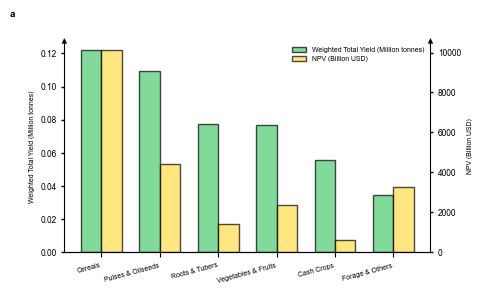

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from matplotlib.patches import FancyArrowPatch

# 设置制图规范（120mm x 70mm = 4.72 x 2.76 inches）
plt.rcParams.update({
    'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
    'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
    'font.family': 'Arial'
})

# 定义作物分类函数：将作物重新分类为6个大类
def classify_crop_to_major_class(crop_name):
    """
    将作物分类为6个大类：
    1. 谷物类 (Cereals)
    2. 豆类和油料 (Pulses & Oilseeds)
    3. 根茎类 (Roots & Tubers)
    4. 蔬菜与水果 (Vegetables & Fruits)
    5. 经济作物 (Cash Crops)
    6. 草料及其他 (Forage & Others)
    """
    # 谷物类
    cereals = ['Wheat', 'Barley', 'Grain maize', 'Millet', 'Sorghum', 'Other cereals', 'Paddy rice']
    
    # 豆类和油料
    pulses_oilseeds = ['Dried pulses', 'Soybeans', 'Sunflower seed', 'Rapeseed and mustard seed', 
                       'Groundnuts', 'Palm kernels', 'Other oilseeds', 'Cotton seed']
    
    # 根茎类
    roots_tubers = ['Potatoes', 'Sweet potato and yams', 'Other roots and tubers', 'Cassava']
    
    # 蔬菜与水果
    vegetables_fruits = ['Other vegetables', 'Other fruits', 'Bananas', 'Citrus fruits', 
                        'Coconuts', 'Olives']
    
    # 经济作物（独立分类）
    cash_crops = ['Coffee, green', 'Tea', 'Cocoa beans', 'Sugar cane', 'Sugar beet', 
                  'Natural rubber', 'Tobacco']
    
    # 草料及其他
    forage_others = ['Other crops', 'Other fibre crops']
    
    if crop_name in cereals:
        return 'Cereals'
    elif crop_name in pulses_oilseeds:
        return 'Pulses & Oilseeds'
    elif crop_name in roots_tubers:
        return 'Roots & Tubers'
    elif crop_name in vegetables_fruits:
        return 'Vegetables & Fruits'
    elif crop_name in cash_crops:
        return 'Cash Crops'
    else:
        return 'Forage & Others'

# 对df_crop_summary按作物分类并计算RCP平均
if len(df_crop_summary) > 0:
    # 添加作物大类列
    df_crop_summary['crop_class'] = df_crop_summary['crop'].apply(classify_crop_to_major_class)
    
    # 第一步：先按作物大类和RCP分组求和（对同一RCP下同一大类内的所有作物求和）
    # 使用加权总产量（weighted_total_yield_tonnes_sum）替代原始总产量
    df_class_rcp_sum = df_crop_summary.groupby(['crop_class', 'RCP']).agg({
        'weighted_yield_kg_dw_ha_mean': 'sum',  # 加权总产量求和
        'npv_usd_sum': 'sum',  # NPV求和
        'area_ha_sum': 'sum'  # 面积求和
    }).reset_index()
    
    # 第二步：再按作物大类分组，对RCP求平均（对重分类求和后的不同RCP取平均）
    df_class_avg = df_class_rcp_sum.groupby('crop_class').agg({
        'weighted_yield_kg_dw_ha_mean': 'mean',  # 加权总产量对RCP取平均
        'npv_usd_sum': 'mean',  # NPV对RCP取平均
        'area_ha_sum': 'mean'  # 面积对RCP取平均
    }).reset_index()
    
    # 按加权产量排序，方便绘图
    df_class_avg = df_class_avg.sort_values('weighted_yield_kg_dw_ha_mean', ascending=False)
    
    # 创建图形（120mm x 70mm = 4.72 x 2.76 inches）
    fig, ax1 = plt.subplots(1, 1, figsize=(120/25.4, 70/25.4))
    
    # 设置x轴位置
    x = np.arange(len(df_class_avg))
    width = 0.35
    
    # 左y轴：加权产量（吨）
    color1 = '#4ccb70'  # 绿色
    bars1 = ax1.bar(x - width/2, df_class_avg['weighted_yield_kg_dw_ha_mean'] / 1e6, 
                    width, label='Weighted Total Yield (Million tonnes)', color=color1, alpha=0.7,
                    edgecolor='black', linewidth=1)
    ax1.set_ylabel('Weighted Total Yield (Million tonnes)', color='black', fontsize=5)
    ax1.tick_params(axis='y', labelcolor='black', labelsize=5)
    ax1.tick_params(axis='x', labelsize=6, labelcolor='black')

    # 右y轴：净现值（百万美元）
    ax2 = ax1.twinx()
    color2 = '#fede4b'  # 黄色
    bars2 = ax2.bar(x + width/2, df_class_avg['npv_usd_sum'] / 1e9, 
                    width, label='NPV (Billion USD)', color=color2, alpha=0.7,edgecolor='black',linewidth=1)
    ax2.set_ylabel('NPV (Billion USD)', color='black', fontsize=5)
    ax2.tick_params(axis='y', labelcolor='black', width=1, size=2, labelsize=6, color='black')

    # 设置x轴标签
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_class_avg['crop_class'], rotation=15, ha='right', fontsize=5, color='black')
    ax1.tick_params(axis='y', labelcolor='black', width=1, size=2, labelsize=6, color='black')

    # 去除上框和右框
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)  # ax1隐藏右框，因为右y轴由ax2负责
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)  # ax2隐藏左框，因为左y轴由ax1负责
    # 取消主图和副图的网格
    ax1.grid(False)
    ax2.grid(False)
    # 获取y轴范围用于添加箭头
    y_lim = ax1.get_ylim()
    y_lim2 = ax2.get_ylim()  

    arrow_y = FancyArrowPatch(
        posA=(0, y_lim[1]),
        posB=(0, y_lim[1] + (y_lim[1] - y_lim[0]) * 0.01),
        transform=ax1.get_yaxis_transform(),
        arrowstyle='simple',
        color='black', linewidth=0, mutation_scale=8, zorder=9
    )
    arrow_y.set_clip_on(False)
    ax1.add_patch(arrow_y)
    
    # 添加右y轴的fancyarrow（在右边缘，x=1，使用transAxes）
    arrow_y2 = FancyArrowPatch(
        posA=(1.0, 1.0),
        posB=(1.0, 1.01),
        transform=ax2.transAxes,
        arrowstyle='simple',
        color='black', linewidth=0, mutation_scale=8, zorder=9
    )
    arrow_y2.set_clip_on(False)
    ax2.add_patch(arrow_y2)
    
    # 添加图例（放在右上角），并去除外框线
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    legend = ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=5, framealpha=0.9)
    legend.get_frame().set_linewidth(0)  # 去除图例外框线

    
    # 添加左上角标记（参照S6_Statistic_inference.ipynb的方式）
    fig.text(0.01, 0.99, "a", ha='left', va='top', fontsize=7, fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)
    
    
    # 创建输出目录并保存图片（参照S6_Statistic_inference.ipynb的方式）
    output_dir = Path('Supplymentary_figure')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    filename_png = output_dir / 'crop_production_economic_benefits.png'
    filename_pdf = output_dir / 'crop_production_economic_benefits.pdf'
    
    fig.savefig(filename_png, dpi=300, bbox_inches='tight', facecolor='white')
    fig.savefig(filename_pdf, dpi=300, bbox_inches='tight', facecolor='none')
    
    print(f"\n图片已保存到: {filename_png}")
    print(f"图片已保存到: {filename_pdf}")
    
    # 显示分类汇总统计
    print("\n作物分类汇总（RCP平均）:")
    print(df_class_avg.to_string(index=False))
else:
    print("警告: df_crop_summary为空，无法绘图")
